In [1]:
from transformers import RobertaModel, RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [2]:
import json


all_spans = {}

with open("../../mfc_v4.0/spans_with_context.json", "r") as f:
    all_spans = json.load(f)
    
articles = all_spans["articles"]
spans = all_spans["spans"]

a_deleted = 0
for article in list(articles.keys()):
    if len(tokenizer(articles[article])['input_ids']) >= 512:
        del articles[article]
        a_deleted += 1
        
s_deleted = 0
filtered_spans = []
for span in spans:
    if span[-1] not in articles:
        s_deleted += 1
        continue
    filtered_spans.append(span)
    
spans = filtered_spans
labels = list(set(e[0] for e in spans))

print("Deleted {} articles and {} spans to fit bert input size".format(a_deleted, s_deleted))

Token indices sequence length is longer than the specified maximum sequence length for this model (3016 > 512). Running this sequence through the model will result in indexing errors


Deleted 321 articles and 8147 spans to fit bert input size


In [3]:
codebook=None
with open("../../mfc_v4.0/codes.json", "r") as f:
    codebook = json.load(f)

In [4]:
len(articles)

31693

In [4]:
labels

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0]

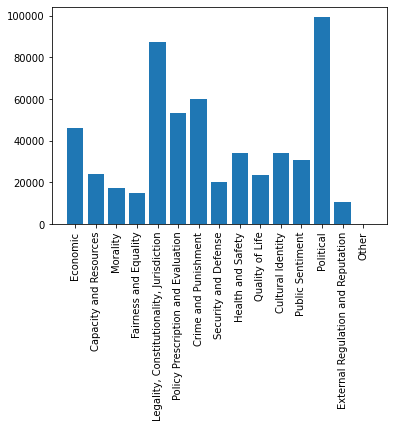

In [5]:
import matplotlib.pyplot as plt
n_spans_per_label = [0]*len(labels)
for span in spans:
    n_spans_per_label[labels.index(span[0])] += 1

plt.xticks(rotation=90)
plt.ylabel("")
plt.bar([codebook[str(label)] for label in labels], n_spans_per_label)
plt.show()

In [6]:
import torch
import torch.nn as NN
from torch.nn.functional import normalize


class FullContextSpanClassifier(NN.Module):
    def __init__(self, labels, reporting=False):
        
        super().__init__()
        self.transformer = RobertaModel.from_pretrained("roberta-base")
        for params in self.transformer.parameters():
            params.requires_grad = False
        self.transformer.eval()
        self.fc = NN.Linear(768, len(labels))
        self.logits = NN.Softmax()
        self.labels = labels
        self.reporting=reporting
    
    def forward(self, x):
        tokens = x[0]
        indices = x[1]
        dims = list(indices.shape)
        indices = torch.flatten(indices)
        
        self.report("Data unpacked. running bigbird...")
        
        x = self.transformer(**tokens).last_hidden_state
        
        self.report("bigbird run. applying mask and summing...")
        
        x = torch.reshape(x, (dims[0]*dims[1], 768))
        self.report("mask shape:", indices.shape, "data shape:", x.shape)
        
        x = (x.t()*indices).t()
        self.report("after masking, data is of shape", x.shape)
        x = torch.reshape(x, (dims[0], dims[1], 768))
        
        x = torch.sum(x, dim=1)
        self.report("after summing, data is of shape", x.shape)
        
        x = normalize(x, dim=1)
        
        x = self.fc(x)
        
        x = self.logits(x)
        
        self.report("classifier run.")
        
        return x
    
    def report(self,*args):
        if self.reporting:
            print("(FullContextSpanClassifier): ", " ".join([str(x) for x in args]))

In [7]:
import random

In [8]:
def calc_annotation_mask(offset_mapping, batch_bounds):
    token_spans = []
    for i, inp in enumerate(offset_mapping):

        start_idx = -1
        end_idx = -1

        for j, span in enumerate(inp):
            tok_start = span[0]
            tok_end = span[1]
            annotation_start = batch_bounds[i][0]
            annotation_end = batch_bounds[i][1]
            if tok_end > annotation_start and start_idx == -1:
                start_idx = j
            if tok_end > annotation_end:
                end_idx = j
                break
        token_spans.append([1 if i >= start_idx and i < end_idx else 0 for i in range(len(inp))])
    return token_spans

In [9]:
from matplotlib import pyplot as plt

def plot_losses(train_losses, test_losses =None):
    domain = list(range(len(train_losses)))
    
    print("Train Loss Shape: ")
    
    plt.plot(domain, train_losses, label="train")
    plt.plot(domain, test_losses, label="test")

    plt.legend()

    plt.show()

In [16]:
#returns arrays of data and labels
def construct_batches(data_x, data_y, size):
    x_batches = []
    y_batches = []
    for i in range(len(data_x)//size):
        batch_x = data_x[i*size:(i+1)*batch_size]
        batch_y = torch.tensor(data_y[i*batch_size:(i+1)*batch_size]).to(device)
        x_batches.append(batch_x)
        y_batches.append(batch_y)
        
    return x_batches, y_batches

def get_batch_input(x_batch,y_batch,articles,only_spans,tokenizer,device):
    
    tokenizer_inp = [articles[x[-1]] for x in x_batch]
    if only_spans:
        tokenizer_inp = [tokenizer_inp[i][x[0]:x[1]] for i,x in enumerate(x_batch)]
    batch_tokens = tokenizer(tokenizer_inp, padding=True, truncation=True, return_offsets_mapping=True, return_tensors='pt')

    slice_tensor = torch.ones(batch_tokens['input_ids'].shape)
    if not only_spans:
        annotation_mask = calc_annotation_mask(batch_tokens["offset_mapping"], x_batch)
        slice_tensor = torch.tensor(annotation_mask, dtype=torch.float)
    del batch_tokens["offset_mapping"]
    model_input = [batch_tokens.to(device), slice_tensor.to(device)]
    
    return model_input
    
def train_model_on_batch(model, x_batch, y_batch, optimizer, articles, only_spans, tokenizer, device, report_loss=False):
    
    model_input = get_batch_input(x_batch, y_batch, articles, only_spans, tokenizer, device)

    y_train_pred = model(model_input)
    train_loss = loss_fn(y_train_pred, y_batch)
    if report_loss:
        print("Training Loss at step",step,":",train_loss.item())

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()
    
    return train_loss.item()

def test_model_on_batch(model,tokenizer,x_batch,y_batch,articles,only_spans,device, loss):
    
    model_input = get_batch_input(x_batch,y_batch,articles,only_spans,tokenizer,device)
    
    model_out = model(model_input)
    
    test_loss = loss_fn(model_out, y_batch)
    
    y_test_pred = torch.argmax(model_out, dim=1).tolist()
    
    y_true = y_batch.tolist()
    
    return test_loss.item(), [(y_test_pred[i],y_true[i]) for i in range(len(y_true))]
    
    
def test_model(model, tokenizer, x_batches, y_batches, articles, only_spans, device, loss):
    
    predictions = []
    loss = []
    
    for i in range(len(x_batches)):
        batch_loss, batch_predictions = test_model_on_batch(model,tokenizer,x_batches[i],y_batches[i],articles,only_spans,device, loss)
        predictions = predictions + batch_predictions
        loss.append(batch_loss)
    
    print("Model Accuracy:", sum(1 if p[0]==p[1] else 0 for p in predictions)/len(predictions))
    
    return sum(loss)/len(loss), predictions

In [17]:
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
only_spans = True
#subset_size = 200
subset_size = len(spans)
data = spans[:subset_size]
batch_size = 16
batches_before_test = 1000
n_epochs = 2
test_size = 2000

data = [ [labels.index(d[0]),d[1],d[2],d[3]] for d in data]
random.seed(2022)
random.shuffle(data)

test_x, test_y = [d[1:] for d in data[:test_size]], [d[0] for d in data[:test_size]]
test_x_batches,test_y_batches = construct_batches(test_x, test_y, batch_size)

train_x, train_y = [d[1:] for d in data[test_size:]], [d[0] for d in data[test_size:]]
train_x_batches,train_y_batches = construct_batches(train_x, train_y, batch_size)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
learning_rate = 5e-4

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training Loss at step 0 : 2.706890106201172
Training Loss at step 10 : 2.7042644023895264
Training Loss at step 20 : 2.704943895339966
Training Loss at step 30 : 2.705030679702759
Training Loss at step 40 : 2.696821928024292
Training Loss at step 50 : 2.702054738998413
Training Loss at step 60 : 2.6989169120788574
Training Loss at step 70 : 2.6996922492980957
Training Loss at step 80 : 2.697613000869751
Training Loss at step 90 : 2.6940886974334717
Training Loss at step 100 : 2.694727897644043
Training Loss at step 110 : 2.6961634159088135
Training Loss at step 120 : 2.699409008026123
Training Loss at step 130 : 2.6824729442596436
Training Loss at step 140 : 2.6925160884857178
Training Loss at step 150 : 2.6967692375183105
Training Loss at step 160 : 2.687046766281128
Training Loss at step 170 : 2.678961753845215
Training Loss at step 180 : 2.6755542755126953
Training Loss at step 190 : 2.6948533058166504
Training Loss at step 200 : 2.6710033416748047
Training Loss at step 210 : 2.6681

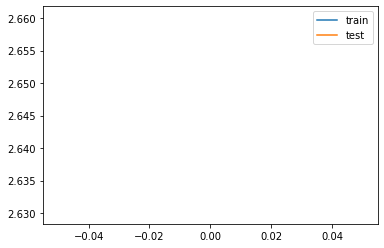

Training Loss at step 1010 : 2.614415407180786
Training Loss at step 1020 : 2.664825916290283
Training Loss at step 1030 : 2.6418352127075195
Training Loss at step 1040 : 2.55637788772583
Training Loss at step 1050 : 2.595881938934326
Training Loss at step 1060 : 2.6860158443450928
Training Loss at step 1070 : 2.6478140354156494
Training Loss at step 1080 : 2.6520607471466064
Training Loss at step 1090 : 2.582261323928833
Training Loss at step 1100 : 2.6496310234069824
Training Loss at step 1110 : 2.6289165019989014
Training Loss at step 1120 : 2.6547374725341797
Training Loss at step 1130 : 2.6588246822357178
Training Loss at step 1140 : 2.6173229217529297
Training Loss at step 1150 : 2.649381399154663
Training Loss at step 1160 : 2.5675923824310303
Training Loss at step 1170 : 2.60794997215271
Training Loss at step 1180 : 2.6470160484313965
Training Loss at step 1190 : 2.6866016387939453
Training Loss at step 1200 : 2.6878793239593506
Training Loss at step 1210 : 2.711073398590088
Tr

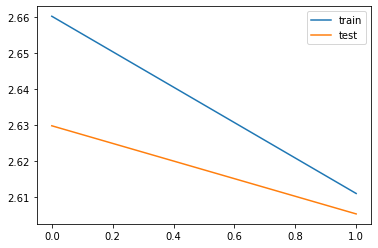

Training Loss at step 2010 : 2.6025047302246094
Training Loss at step 2020 : 2.5931034088134766
Training Loss at step 2030 : 2.657435655593872
Training Loss at step 2040 : 2.6325430870056152
Training Loss at step 2050 : 2.5612776279449463
Training Loss at step 2060 : 2.567615270614624
Training Loss at step 2070 : 2.541281223297119
Training Loss at step 2080 : 2.5739829540252686
Training Loss at step 2090 : 2.4605298042297363
Training Loss at step 2100 : 2.583526134490967
Training Loss at step 2110 : 2.5930049419403076
Training Loss at step 2120 : 2.5571696758270264
Training Loss at step 2130 : 2.6069912910461426
Training Loss at step 2140 : 2.6572253704071045
Training Loss at step 2150 : 2.5822694301605225
Training Loss at step 2160 : 2.674302339553833
Training Loss at step 2170 : 2.6423842906951904
Training Loss at step 2180 : 2.593146562576294
Training Loss at step 2190 : 2.5002472400665283
Training Loss at step 2200 : 2.63820219039917
Training Loss at step 2210 : 2.5603837966918945


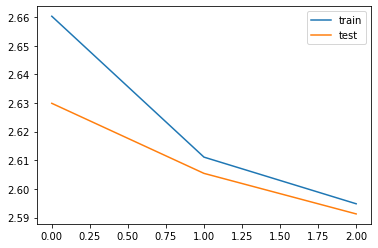

Training Loss at step 3010 : 2.5068726539611816
Training Loss at step 3020 : 2.4943325519561768
Training Loss at step 3030 : 2.5875356197357178
Training Loss at step 3040 : 2.6575655937194824
Training Loss at step 3050 : 2.57446026802063
Training Loss at step 3060 : 2.634944438934326
Training Loss at step 3070 : 2.63114857673645
Training Loss at step 3080 : 2.6058669090270996
Training Loss at step 3090 : 2.534360885620117
Training Loss at step 3100 : 2.4828145503997803
Training Loss at step 3110 : 2.55906081199646
Training Loss at step 3120 : 2.6754376888275146
Training Loss at step 3130 : 2.458998918533325
Training Loss at step 3140 : 2.587757110595703
Training Loss at step 3150 : 2.536290407180786
Training Loss at step 3160 : 2.523054599761963
Training Loss at step 3170 : 2.48398756980896
Training Loss at step 3180 : 2.548891067504883
Training Loss at step 3190 : 2.5496561527252197
Training Loss at step 3200 : 2.5655341148376465
Training Loss at step 3210 : 2.5141820907592773
Trainin

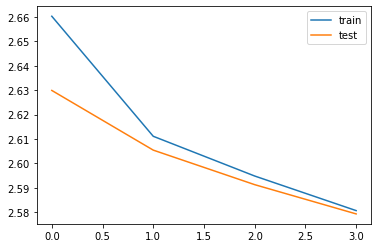

Training Loss at step 4010 : 2.6133100986480713
Training Loss at step 4020 : 2.6040937900543213
Training Loss at step 4030 : 2.5401196479797363
Training Loss at step 4040 : 2.512929677963257
Training Loss at step 4050 : 2.60117506980896
Training Loss at step 4060 : 2.6036980152130127
Training Loss at step 4070 : 2.5531022548675537
Training Loss at step 4080 : 2.5664522647857666
Training Loss at step 4090 : 2.5920820236206055
Training Loss at step 4100 : 2.6575164794921875
Training Loss at step 4110 : 2.6569933891296387
Training Loss at step 4120 : 2.371443748474121
Training Loss at step 4130 : 2.50764536857605
Training Loss at step 4140 : 2.596717596054077
Training Loss at step 4150 : 2.5308046340942383
Training Loss at step 4160 : 2.5503532886505127
Training Loss at step 4170 : 2.583930492401123
Training Loss at step 4180 : 2.561211585998535
Training Loss at step 4190 : 2.5305562019348145
Training Loss at step 4200 : 2.563246011734009
Training Loss at step 4210 : 2.658125162124634
Tra

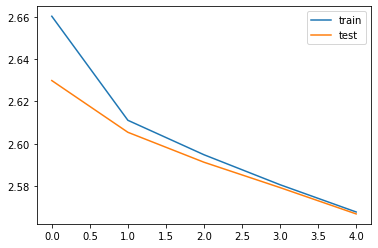

Training Loss at step 5010 : 2.554365873336792
Training Loss at step 5020 : 2.5278520584106445
Training Loss at step 5030 : 2.5594732761383057
Training Loss at step 5040 : 2.543567419052124
Training Loss at step 5050 : 2.607868194580078
Training Loss at step 5060 : 2.6364970207214355
Training Loss at step 5070 : 2.5620901584625244
Training Loss at step 5080 : 2.628713607788086
Training Loss at step 5090 : 2.65325927734375
Training Loss at step 5100 : 2.6249771118164062
Training Loss at step 5110 : 2.5603888034820557
Training Loss at step 5120 : 2.571861743927002
Training Loss at step 5130 : 2.526994228363037
Training Loss at step 5140 : 2.4672985076904297
Training Loss at step 5150 : 2.54610013961792
Training Loss at step 5160 : 2.5874829292297363
Training Loss at step 5170 : 2.6297836303710938
Training Loss at step 5180 : 2.591073751449585
Training Loss at step 5190 : 2.494544267654419
Training Loss at step 5200 : 2.6232213973999023
Training Loss at step 5210 : 2.5725200176239014
Trai

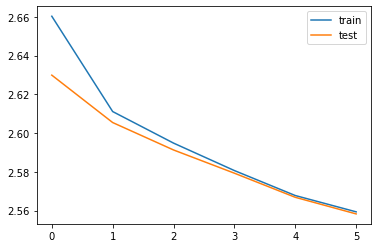

Training Loss at step 6010 : 2.6346065998077393
Training Loss at step 6020 : 2.631460189819336
Training Loss at step 6030 : 2.5992681980133057
Training Loss at step 6040 : 2.5033841133117676
Training Loss at step 6050 : 2.48563814163208
Training Loss at step 6060 : 2.521465301513672
Training Loss at step 6070 : 2.507014751434326
Training Loss at step 6080 : 2.5600638389587402
Training Loss at step 6090 : 2.6443514823913574
Training Loss at step 6100 : 2.6303281784057617
Training Loss at step 6110 : 2.4884700775146484
Training Loss at step 6120 : 2.658470392227173
Training Loss at step 6130 : 2.5600316524505615
Training Loss at step 6140 : 2.4347612857818604
Training Loss at step 6150 : 2.4690377712249756
Training Loss at step 6160 : 2.441688060760498
Training Loss at step 6170 : 2.6267640590667725
Training Loss at step 6180 : 2.492105484008789
Training Loss at step 6190 : 2.5615272521972656
Training Loss at step 6200 : 2.57212233543396
Training Loss at step 6210 : 2.6267759799957275
Tr

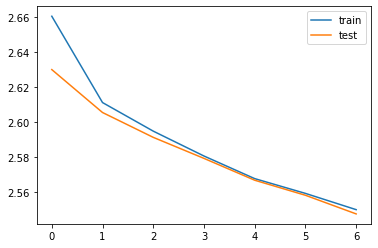

Training Loss at step 7010 : 2.584080219268799
Training Loss at step 7020 : 2.6349525451660156
Training Loss at step 7030 : 2.5186455249786377
Training Loss at step 7040 : 2.5572352409362793
Training Loss at step 7050 : 2.4799575805664062
Training Loss at step 7060 : 2.5337016582489014
Training Loss at step 7070 : 2.527346611022949
Training Loss at step 7080 : 2.6117475032806396
Training Loss at step 7090 : 2.575312852859497
Training Loss at step 7100 : 2.590049982070923
Training Loss at step 7110 : 2.410165548324585
Training Loss at step 7120 : 2.5077452659606934
Training Loss at step 7130 : 2.571986198425293
Training Loss at step 7140 : 2.55924654006958
Training Loss at step 7150 : 2.4105889797210693
Training Loss at step 7160 : 2.5388174057006836
Training Loss at step 7170 : 2.629373788833618
Training Loss at step 7180 : 2.5363011360168457
Training Loss at step 7190 : 2.609834909439087
Training Loss at step 7200 : 2.5626137256622314
Training Loss at step 7210 : 2.5609657764434814
Tr

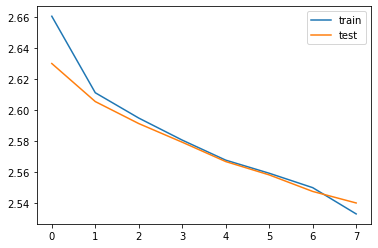

Training Loss at step 8010 : 2.56457257270813
Training Loss at step 8020 : 2.505171298980713
Training Loss at step 8030 : 2.507195472717285
Training Loss at step 8040 : 2.558892011642456
Training Loss at step 8050 : 2.516024112701416
Training Loss at step 8060 : 2.6112308502197266
Training Loss at step 8070 : 2.448166847229004
Training Loss at step 8080 : 2.552736520767212
Training Loss at step 8090 : 2.5326755046844482
Training Loss at step 8100 : 2.535721778869629
Training Loss at step 8110 : 2.440758466720581
Training Loss at step 8120 : 2.5730907917022705
Training Loss at step 8130 : 2.5644443035125732
Training Loss at step 8140 : 2.492070436477661
Training Loss at step 8150 : 2.485200881958008
Training Loss at step 8160 : 2.6827480792999268
Training Loss at step 8170 : 2.584359645843506
Training Loss at step 8180 : 2.367478847503662
Training Loss at step 8190 : 2.550529718399048
Training Loss at step 8200 : 2.554161548614502
Training Loss at step 8210 : 2.5080723762512207
Training

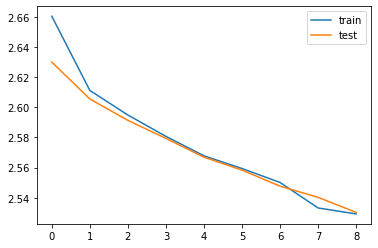

Training Loss at step 9010 : 2.582897186279297
Training Loss at step 9020 : 2.5603199005126953
Training Loss at step 9030 : 2.59014630317688
Training Loss at step 9040 : 2.5063393115997314
Training Loss at step 9050 : 2.562681198120117
Training Loss at step 9060 : 2.586413860321045
Training Loss at step 9070 : 2.5703439712524414
Training Loss at step 9080 : 2.563265085220337
Training Loss at step 9090 : 2.6131818294525146
Training Loss at step 9100 : 2.6061477661132812
Training Loss at step 9110 : 2.450333595275879
Training Loss at step 9120 : 2.5100009441375732
Training Loss at step 9130 : 2.4748687744140625
Training Loss at step 9140 : 2.536717653274536
Training Loss at step 9150 : 2.4707841873168945
Training Loss at step 9160 : 2.558525800704956
Training Loss at step 9170 : 2.520237684249878
Training Loss at step 9180 : 2.5451860427856445
Training Loss at step 9190 : 2.526862859725952
Training Loss at step 9200 : 2.4754230976104736
Training Loss at step 9210 : 2.4726076126098633
Tra

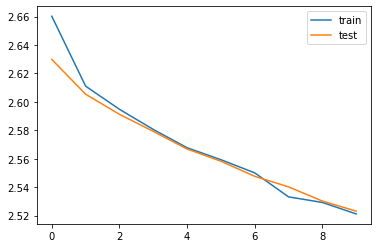

Training Loss at step 10010 : 2.5111114978790283
Training Loss at step 10020 : 2.650129795074463
Training Loss at step 10030 : 2.561270236968994
Training Loss at step 10040 : 2.532850980758667
Training Loss at step 10050 : 2.449085235595703
Training Loss at step 10060 : 2.3758797645568848
Training Loss at step 10070 : 2.513103485107422
Training Loss at step 10080 : 2.469663381576538
Training Loss at step 10090 : 2.4042110443115234
Training Loss at step 10100 : 2.3338398933410645
Training Loss at step 10110 : 2.5103678703308105
Training Loss at step 10120 : 2.3984875679016113
Training Loss at step 10130 : 2.5365958213806152
Training Loss at step 10140 : 2.4199023246765137
Training Loss at step 10150 : 2.501744508743286
Training Loss at step 10160 : 2.4352874755859375
Training Loss at step 10170 : 2.572481870651245
Training Loss at step 10180 : 2.443578004837036
Training Loss at step 10190 : 2.5765252113342285
Training Loss at step 10200 : 2.4207065105438232
Training Loss at step 10210 :

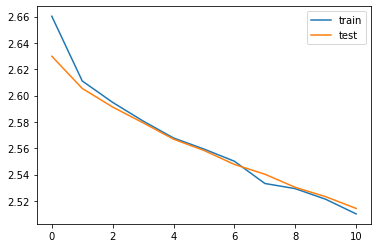

Training Loss at step 11010 : 2.6424856185913086
Training Loss at step 11020 : 2.422811269760132
Training Loss at step 11030 : 2.496034622192383
Training Loss at step 11040 : 2.371481418609619
Training Loss at step 11050 : 2.6657471656799316
Training Loss at step 11060 : 2.4796013832092285
Training Loss at step 11070 : 2.424921751022339
Training Loss at step 11080 : 2.51423716545105
Training Loss at step 11090 : 2.6141481399536133
Training Loss at step 11100 : 2.5271623134613037
Training Loss at step 11110 : 2.4638359546661377
Training Loss at step 11120 : 2.6079602241516113
Training Loss at step 11130 : 2.541757822036743
Training Loss at step 11140 : 2.5273919105529785
Training Loss at step 11150 : 2.5547118186950684
Training Loss at step 11160 : 2.529747724533081
Training Loss at step 11170 : 2.4952633380889893
Training Loss at step 11180 : 2.502394914627075
Training Loss at step 11190 : 2.5251665115356445
Training Loss at step 11200 : 2.6553165912628174
Training Loss at step 11210 :

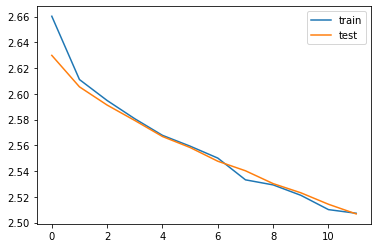

Training Loss at step 12010 : 2.652653932571411
Training Loss at step 12020 : 2.593057155609131
Training Loss at step 12030 : 2.4459826946258545
Training Loss at step 12040 : 2.5240039825439453
Training Loss at step 12050 : 2.470137357711792
Training Loss at step 12060 : 2.414703369140625
Training Loss at step 12070 : 2.40112566947937
Training Loss at step 12080 : 2.491259813308716
Training Loss at step 12090 : 2.554227590560913
Training Loss at step 12100 : 2.577709913253784
Training Loss at step 12110 : 2.3987789154052734
Training Loss at step 12120 : 2.4923768043518066
Training Loss at step 12130 : 2.48809814453125
Training Loss at step 12140 : 2.40834379196167
Training Loss at step 12150 : 2.4846675395965576
Training Loss at step 12160 : 2.2877554893493652
Training Loss at step 12170 : 2.495863437652588
Training Loss at step 12180 : 2.5439913272857666
Training Loss at step 12190 : 2.5155086517333984
Training Loss at step 12200 : 2.482372760772705
Training Loss at step 12210 : 2.476

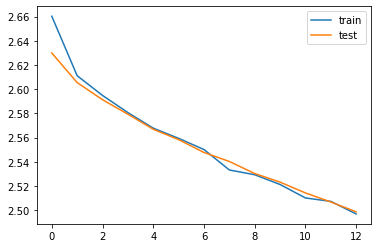

Training Loss at step 13010 : 2.38375186920166
Training Loss at step 13020 : 2.612671136856079
Training Loss at step 13030 : 2.6016366481781006
Training Loss at step 13040 : 2.55713152885437
Training Loss at step 13050 : 2.5244359970092773
Training Loss at step 13060 : 2.4665839672088623
Training Loss at step 13070 : 2.560957908630371
Training Loss at step 13080 : 2.4071569442749023
Training Loss at step 13090 : 2.4815633296966553
Training Loss at step 13100 : 2.443060874938965
Training Loss at step 13110 : 2.4917821884155273
Training Loss at step 13120 : 2.546344757080078
Training Loss at step 13130 : 2.510631799697876
Training Loss at step 13140 : 2.4622907638549805
Training Loss at step 13150 : 2.5321197509765625
Training Loss at step 13160 : 2.3518545627593994
Training Loss at step 13170 : 2.5047295093536377
Training Loss at step 13180 : 2.4360737800598145
Training Loss at step 13190 : 2.5885567665100098
Training Loss at step 13200 : 2.4466376304626465
Training Loss at step 13210 :

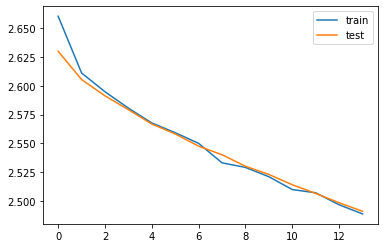

Training Loss at step 14010 : 2.4366588592529297
Training Loss at step 14020 : 2.566118001937866
Training Loss at step 14030 : 2.3497259616851807
Training Loss at step 14040 : 2.5206005573272705
Training Loss at step 14050 : 2.51778244972229
Training Loss at step 14060 : 2.373960018157959
Training Loss at step 14070 : 2.40071964263916
Training Loss at step 14080 : 2.429595947265625
Training Loss at step 14090 : 2.584287166595459
Training Loss at step 14100 : 2.4557745456695557
Training Loss at step 14110 : 2.5021355152130127
Training Loss at step 14120 : 2.470712661743164
Training Loss at step 14130 : 2.5832293033599854
Training Loss at step 14140 : 2.1798079013824463
Training Loss at step 14150 : 2.6047158241271973
Training Loss at step 14160 : 2.505218029022217
Training Loss at step 14170 : 2.4562253952026367
Training Loss at step 14180 : 2.562736988067627
Training Loss at step 14190 : 2.4064924716949463
Training Loss at step 14200 : 2.389159917831421
Training Loss at step 14210 : 2.

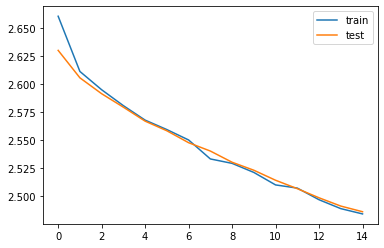

Training Loss at step 15010 : 2.4231832027435303
Training Loss at step 15020 : 2.438872814178467
Training Loss at step 15030 : 2.600687026977539
Training Loss at step 15040 : 2.457516670227051
Training Loss at step 15050 : 2.574009656906128
Training Loss at step 15060 : 2.444889783859253
Training Loss at step 15070 : 2.443075656890869
Training Loss at step 15080 : 2.511988639831543
Training Loss at step 15090 : 2.5116796493530273
Training Loss at step 15100 : 2.5374505519866943
Training Loss at step 15110 : 2.30765438079834
Training Loss at step 15120 : 2.528947353363037
Training Loss at step 15130 : 2.559887409210205
Training Loss at step 15140 : 2.3861935138702393
Training Loss at step 15150 : 2.553971767425537
Training Loss at step 15160 : 2.3616509437561035
Training Loss at step 15170 : 2.4201877117156982
Training Loss at step 15180 : 2.469741106033325
Training Loss at step 15190 : 2.5620827674865723
Training Loss at step 15200 : 2.398824453353882
Training Loss at step 15210 : 2.56

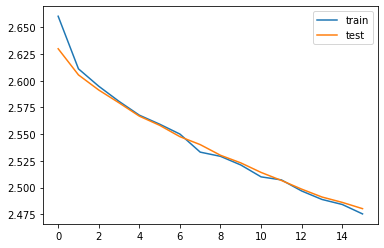

Training Loss at step 16010 : 2.6194310188293457
Training Loss at step 16020 : 2.4099438190460205
Training Loss at step 16030 : 2.5007612705230713
Training Loss at step 16040 : 2.5866892337799072
Training Loss at step 16050 : 2.425807476043701
Training Loss at step 16060 : 2.4211184978485107
Training Loss at step 16070 : 2.481131076812744
Training Loss at step 16080 : 2.595069646835327
Training Loss at step 16090 : 2.457136869430542
Training Loss at step 16100 : 2.448516845703125
Training Loss at step 16110 : 2.3621397018432617
Training Loss at step 16120 : 2.487051486968994
Training Loss at step 16130 : 2.4357168674468994
Training Loss at step 16140 : 2.594327688217163
Training Loss at step 16150 : 2.5669140815734863
Training Loss at step 16160 : 2.454484462738037
Training Loss at step 16170 : 2.5485358238220215
Training Loss at step 16180 : 2.4946045875549316
Training Loss at step 16190 : 2.449760913848877
Training Loss at step 16200 : 2.503145694732666
Training Loss at step 16210 : 

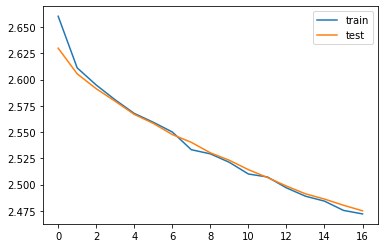

Training Loss at step 17010 : 2.507736921310425
Training Loss at step 17020 : 2.478595495223999
Training Loss at step 17030 : 2.4943172931671143
Training Loss at step 17040 : 2.4543023109436035
Training Loss at step 17050 : 2.466369152069092
Training Loss at step 17060 : 2.5946412086486816
Training Loss at step 17070 : 2.3777718544006348
Training Loss at step 17080 : 2.4397671222686768
Training Loss at step 17090 : 2.375887155532837
Training Loss at step 17100 : 2.4351577758789062
Training Loss at step 17110 : 2.4952855110168457
Training Loss at step 17120 : 2.433462619781494
Training Loss at step 17130 : 2.3517019748687744
Training Loss at step 17140 : 2.3248558044433594
Training Loss at step 17150 : 2.456479072570801
Training Loss at step 17160 : 2.5543248653411865
Training Loss at step 17170 : 2.396688938140869
Training Loss at step 17180 : 2.3826217651367188
Training Loss at step 17190 : 2.337660789489746
Training Loss at step 17200 : 2.5343291759490967
Training Loss at step 17210 

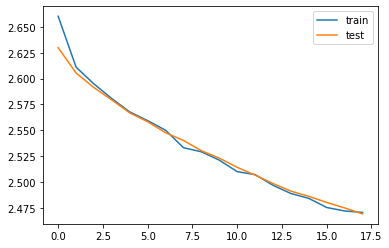

Training Loss at step 18010 : 2.5588765144348145
Training Loss at step 18020 : 2.43729829788208
Training Loss at step 18030 : 2.5643222332000732
Training Loss at step 18040 : 2.4383342266082764
Training Loss at step 18050 : 2.502378225326538
Training Loss at step 18060 : 2.541531562805176
Training Loss at step 18070 : 2.438507318496704
Training Loss at step 18080 : 2.3970303535461426
Training Loss at step 18090 : 2.4422895908355713
Training Loss at step 18100 : 2.4304890632629395
Training Loss at step 18110 : 2.5870933532714844
Training Loss at step 18120 : 2.537278652191162
Training Loss at step 18130 : 2.292445182800293
Training Loss at step 18140 : 2.3037590980529785
Training Loss at step 18150 : 2.510711669921875
Training Loss at step 18160 : 2.3018240928649902
Training Loss at step 18170 : 2.5189573764801025
Training Loss at step 18180 : 2.3052563667297363
Training Loss at step 18190 : 2.3804214000701904
Training Loss at step 18200 : 2.441331386566162
Training Loss at step 18210 :

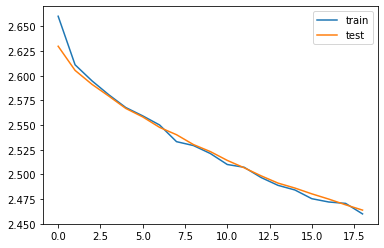

Training Loss at step 19010 : 2.48246693611145
Training Loss at step 19020 : 2.5371198654174805
Training Loss at step 19030 : 2.3577444553375244
Training Loss at step 19040 : 2.4310102462768555
Training Loss at step 19050 : 2.3999946117401123
Training Loss at step 19060 : 2.492828845977783
Training Loss at step 19070 : 2.241419792175293
Training Loss at step 19080 : 2.305372476577759
Training Loss at step 19090 : 2.5001111030578613
Training Loss at step 19100 : 2.6680710315704346
Training Loss at step 19110 : 2.5811142921447754
Training Loss at step 19120 : 2.3548085689544678
Training Loss at step 19130 : 2.3232152462005615
Training Loss at step 19140 : 2.426542282104492
Training Loss at step 19150 : 2.5001232624053955
Training Loss at step 19160 : 2.575535774230957
Training Loss at step 19170 : 2.3889822959899902
Training Loss at step 19180 : 2.4595553874969482
Training Loss at step 19190 : 2.4402413368225098
Training Loss at step 19200 : 2.4044530391693115
Training Loss at step 19210

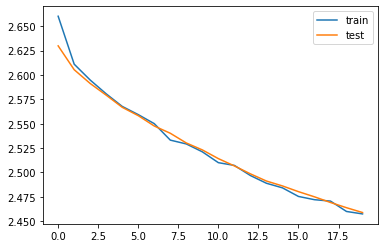

Training Loss at step 20010 : 2.4450745582580566
Training Loss at step 20020 : 2.4921278953552246
Training Loss at step 20030 : 2.4838292598724365
Training Loss at step 20040 : 2.479037284851074
Training Loss at step 20050 : 2.518551826477051
Training Loss at step 20060 : 2.4508957862854004
Training Loss at step 20070 : 2.3332035541534424
Training Loss at step 20080 : 2.4535861015319824
Training Loss at step 20090 : 2.3544280529022217
Training Loss at step 20100 : 2.4978153705596924
Training Loss at step 20110 : 2.3945813179016113
Training Loss at step 20120 : 2.4723122119903564
Training Loss at step 20130 : 2.358286142349243
Training Loss at step 20140 : 2.347560405731201
Training Loss at step 20150 : 2.4478564262390137
Training Loss at step 20160 : 2.418236255645752
Training Loss at step 20170 : 2.4564626216888428
Training Loss at step 20180 : 2.551588773727417
Training Loss at step 20190 : 2.4161550998687744
Training Loss at step 20200 : 2.5224125385284424
Training Loss at step 2021

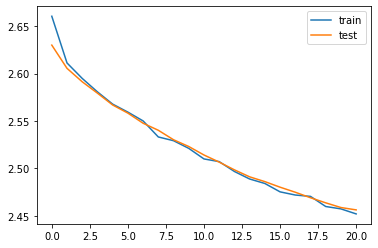

Training Loss at step 21010 : 2.6158294677734375
Training Loss at step 21020 : 2.493506908416748
Training Loss at step 21030 : 2.517094850540161
Training Loss at step 21040 : 2.607041358947754
Training Loss at step 21050 : 2.4866127967834473
Training Loss at step 21060 : 2.48761248588562
Training Loss at step 21070 : 2.4777302742004395
Training Loss at step 21080 : 2.5765440464019775
Training Loss at step 21090 : 2.4044950008392334
Training Loss at step 21100 : 2.5271174907684326
Training Loss at step 21110 : 2.5082809925079346
Training Loss at step 21120 : 2.5737931728363037
Training Loss at step 21130 : 2.4254238605499268
Training Loss at step 21140 : 2.403916120529175
Training Loss at step 21150 : 2.4377129077911377
Training Loss at step 21160 : 2.5399720668792725
Training Loss at step 21170 : 2.4249179363250732
Training Loss at step 21180 : 2.488063335418701
Training Loss at step 21190 : 2.4781553745269775
Training Loss at step 21200 : 2.4751763343811035
Training Loss at step 21210

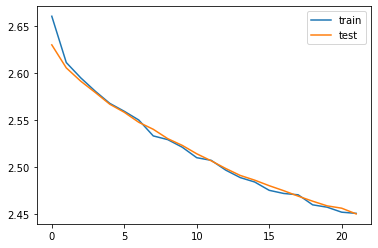

Training Loss at step 22010 : 2.394691228866577
Training Loss at step 22020 : 2.6382200717926025
Training Loss at step 22030 : 2.476248025894165
Training Loss at step 22040 : 2.433441638946533
Training Loss at step 22050 : 2.524177074432373
Training Loss at step 22060 : 2.55794620513916
Training Loss at step 22070 : 2.275904417037964
Training Loss at step 22080 : 2.5076682567596436
Training Loss at step 22090 : 2.5870862007141113
Training Loss at step 22100 : 2.4153101444244385
Training Loss at step 22110 : 2.5210020542144775
Training Loss at step 22120 : 2.4052717685699463
Training Loss at step 22130 : 2.4124341011047363
Training Loss at step 22140 : 2.446690559387207
Training Loss at step 22150 : 2.5472426414489746
Training Loss at step 22160 : 2.4484212398529053
Training Loss at step 22170 : 2.1766774654388428
Training Loss at step 22180 : 2.385249376296997
Training Loss at step 22190 : 2.4286510944366455
Training Loss at step 22200 : 2.454113006591797
Training Loss at step 22210 : 

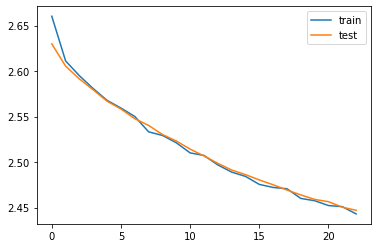

Training Loss at step 23010 : 2.5113439559936523
Training Loss at step 23020 : 2.600391387939453
Training Loss at step 23030 : 2.4577934741973877
Training Loss at step 23040 : 2.3944573402404785
Training Loss at step 23050 : 2.3269827365875244
Training Loss at step 23060 : 2.440171241760254
Training Loss at step 23070 : 2.422410011291504
Training Loss at step 23080 : 2.401381015777588
Training Loss at step 23090 : 2.349696397781372
Training Loss at step 23100 : 2.5095551013946533
Training Loss at step 23110 : 2.3547208309173584
Training Loss at step 23120 : 2.4408974647521973
Training Loss at step 23130 : 2.458449125289917
Training Loss at step 23140 : 2.3962879180908203
Training Loss at step 23150 : 2.5254178047180176
Training Loss at step 23160 : 2.390615940093994
Training Loss at step 23170 : 2.3839383125305176
Training Loss at step 23180 : 2.3725626468658447
Training Loss at step 23190 : 2.325343370437622
Training Loss at step 23200 : 2.4526190757751465
Training Loss at step 23210 

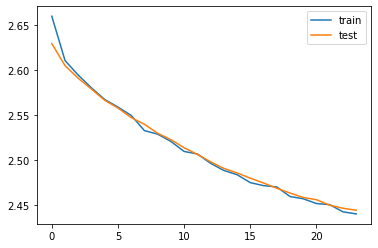

Training Loss at step 24010 : 2.6777544021606445
Training Loss at step 24020 : 2.4914309978485107
Training Loss at step 24030 : 2.4284908771514893
Training Loss at step 24040 : 2.381114959716797
Training Loss at step 24050 : 2.527430534362793
Training Loss at step 24060 : 2.4530766010284424
Training Loss at step 24070 : 2.4686975479125977
Training Loss at step 24080 : 2.481112241744995
Training Loss at step 24090 : 2.510363817214966
Training Loss at step 24100 : 2.4375853538513184
Training Loss at step 24110 : 2.383164405822754
Training Loss at step 24120 : 2.3972434997558594
Training Loss at step 24130 : 2.504894256591797
Training Loss at step 24140 : 2.452141523361206
Training Loss at step 24150 : 2.340317726135254
Training Loss at step 24160 : 2.589238405227661
Training Loss at step 24170 : 2.449174404144287
Training Loss at step 24180 : 2.3631112575531006
Training Loss at step 24190 : 2.4652204513549805
Training Loss at step 24200 : 2.2991490364074707
Training Loss at step 24210 : 

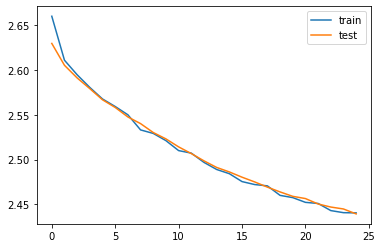

Training Loss at step 25010 : 2.4541192054748535
Training Loss at step 25020 : 2.393406629562378
Training Loss at step 25030 : 2.3704943656921387
Training Loss at step 25040 : 2.533935070037842
Training Loss at step 25050 : 2.444524049758911
Training Loss at step 25060 : 2.514857769012451
Training Loss at step 25070 : 2.526968240737915
Training Loss at step 25080 : 2.421321392059326
Training Loss at step 25090 : 2.4837112426757812
Training Loss at step 25100 : 2.4835991859436035
Training Loss at step 25110 : 2.4496452808380127
Training Loss at step 25120 : 2.3772268295288086
Training Loss at step 25130 : 2.4847397804260254
Training Loss at step 25140 : 2.619837522506714
Training Loss at step 25150 : 2.5405068397521973
Training Loss at step 25160 : 2.388702869415283
Training Loss at step 25170 : 2.5155317783355713
Training Loss at step 25180 : 2.3310277462005615
Training Loss at step 25190 : 2.463024616241455
Training Loss at step 25200 : 2.476834535598755
Training Loss at step 25210 : 

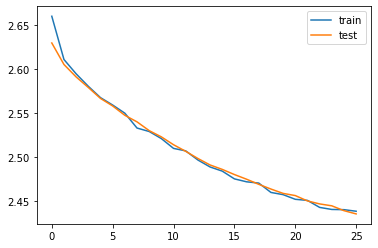

Training Loss at step 26010 : 2.396761178970337
Training Loss at step 26020 : 2.443645715713501
Training Loss at step 26030 : 2.3495171070098877
Training Loss at step 26040 : 2.6227028369903564
Training Loss at step 26050 : 2.508549928665161
Training Loss at step 26060 : 2.4045207500457764
Training Loss at step 26070 : 2.5004634857177734
Training Loss at step 26080 : 2.427483081817627
Training Loss at step 26090 : 2.2920219898223877
Training Loss at step 26100 : 2.371246099472046
Training Loss at step 26110 : 2.6023685932159424
Training Loss at step 26120 : 2.4344263076782227
Training Loss at step 26130 : 2.4461255073547363
Training Loss at step 26140 : 2.4969441890716553
Training Loss at step 26150 : 2.4683420658111572
Training Loss at step 26160 : 2.35652756690979
Training Loss at step 26170 : 2.620211601257324
Training Loss at step 26180 : 2.420382261276245
Training Loss at step 26190 : 2.4553771018981934
Training Loss at step 26200 : 2.4802322387695312
Training Loss at step 26210 :

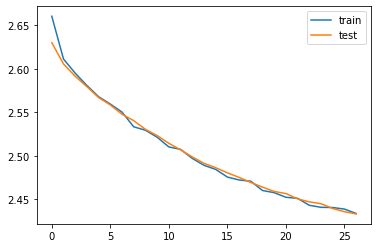

Training Loss at step 27010 : 2.3682432174682617
Training Loss at step 27020 : 2.5543534755706787
Training Loss at step 27030 : 2.385936975479126
Training Loss at step 27040 : 2.345771551132202
Training Loss at step 27050 : 2.453789710998535
Training Loss at step 27060 : 2.2828409671783447
Training Loss at step 27070 : 2.412099599838257
Training Loss at step 27080 : 2.363558053970337
Training Loss at step 27090 : 2.615830183029175
Training Loss at step 27100 : 2.3582136631011963
Training Loss at step 27110 : 2.3795857429504395
Training Loss at step 27120 : 2.409231424331665
Training Loss at step 27130 : 2.356661558151245
Training Loss at step 27140 : 2.2824113368988037
Training Loss at step 27150 : 2.436905860900879
Training Loss at step 27160 : 2.4924492835998535
Training Loss at step 27170 : 2.3446204662323
Training Loss at step 27180 : 2.4740233421325684
Training Loss at step 27190 : 2.3598039150238037
Training Loss at step 27200 : 2.5076072216033936
Training Loss at step 27210 : 2.

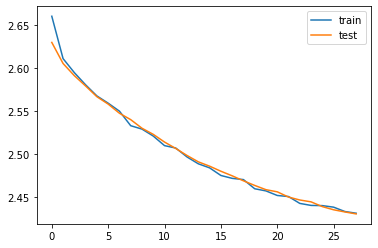

Training Loss at step 28010 : 2.3644301891326904
Training Loss at step 28020 : 2.530991315841675
Training Loss at step 28030 : 2.2981808185577393
Training Loss at step 28040 : 2.261622428894043
Training Loss at step 28050 : 2.433570623397827
Training Loss at step 28060 : 2.4068398475646973
Training Loss at step 28070 : 2.507986545562744
Training Loss at step 28080 : 2.5133755207061768
Training Loss at step 28090 : 2.4983630180358887
Training Loss at step 28100 : 2.4444420337677
Training Loss at step 28110 : 2.4620025157928467
Training Loss at step 28120 : 2.3569929599761963
Training Loss at step 28130 : 2.450873374938965
Training Loss at step 28140 : 2.5467793941497803
Training Loss at step 28150 : 2.4936890602111816
Training Loss at step 28160 : 2.329238176345825
Training Loss at step 28170 : 2.434999465942383
Training Loss at step 28180 : 2.3605153560638428
Training Loss at step 28190 : 2.5009925365448
Training Loss at step 28200 : 2.5240395069122314
Training Loss at step 28210 : 2.5

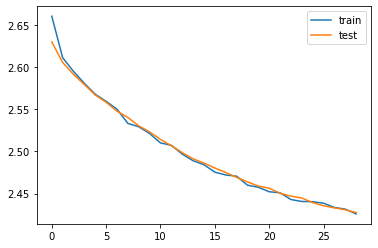

Training Loss at step 29010 : 2.5484516620635986
Training Loss at step 29020 : 2.4851016998291016
Training Loss at step 29030 : 2.5541341304779053
Training Loss at step 29040 : 2.4521007537841797
Training Loss at step 29050 : 2.4999749660491943
Training Loss at step 29060 : 2.32155179977417
Training Loss at step 29070 : 2.4510746002197266
Training Loss at step 29080 : 2.3381268978118896
Training Loss at step 29090 : 2.479766368865967
Training Loss at step 29100 : 2.35799503326416
Training Loss at step 29110 : 2.333508014678955
Training Loss at step 29120 : 2.4804139137268066
Training Loss at step 29130 : 2.485412359237671
Training Loss at step 29140 : 2.4335038661956787
Training Loss at step 29150 : 2.4357070922851562
Training Loss at step 29160 : 2.48687744140625
Training Loss at step 29170 : 2.3318212032318115
Training Loss at step 29180 : 2.3868024349212646
Training Loss at step 29190 : 2.4532997608184814
Training Loss at step 29200 : 2.390164852142334
Training Loss at step 29210 : 

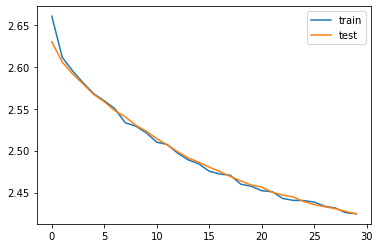

Training Loss at step 30010 : 2.348376750946045
Training Loss at step 30020 : 2.532034397125244
Training Loss at step 30030 : 2.3019189834594727
Training Loss at step 30040 : 2.376551389694214
Training Loss at step 30050 : 2.493340492248535
Training Loss at step 30060 : 2.401576280593872
Training Loss at step 30070 : 2.4222824573516846
Training Loss at step 30080 : 2.517716407775879
Training Loss at step 30090 : 2.3818953037261963
Training Loss at step 30100 : 2.4561729431152344
Training Loss at step 30110 : 2.5734541416168213
Training Loss at step 30120 : 2.4383277893066406
Training Loss at step 30130 : 2.3852107524871826
Training Loss at step 30140 : 2.3648221492767334
Training Loss at step 30150 : 2.4987142086029053
Training Loss at step 30160 : 2.2835471630096436
Training Loss at step 30170 : 2.3778903484344482
Training Loss at step 30180 : 2.431225538253784
Training Loss at step 30190 : 2.531151533126831
Training Loss at step 30200 : 2.510183334350586
Training Loss at step 30210 :

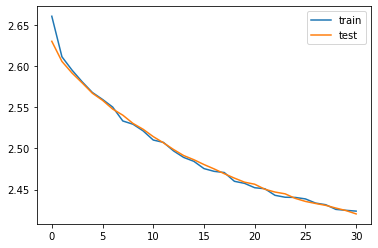

Training Loss at step 31010 : 2.3450615406036377
Training Loss at step 31020 : 2.388230323791504
Training Loss at step 31030 : 2.4259955883026123
Training Loss at step 31040 : 2.5079076290130615
Training Loss at step 31050 : 2.3835623264312744
Training Loss at step 31060 : 2.3006250858306885
Training Loss at step 31070 : 2.4168403148651123
Training Loss at step 31080 : 2.4605391025543213
Training Loss at step 31090 : 2.4119656085968018
Training Loss at step 31100 : 2.3915019035339355
Training Loss at step 31110 : 2.3686537742614746
Training Loss at step 31120 : 2.508190870285034
Training Loss at step 31130 : 2.345637083053589
Training Loss at step 31140 : 2.519880533218384
Training Loss at step 31150 : 2.4571118354797363
Training Loss at step 31160 : 2.5335826873779297
Training Loss at step 31170 : 2.3832762241363525
Training Loss at step 31180 : 2.37465763092041
Training Loss at step 31190 : 2.2981984615325928
Training Loss at step 31200 : 2.4554343223571777
Training Loss at step 3121

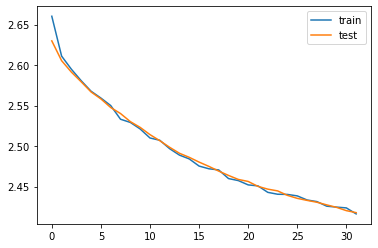

Training Loss at step 32010 : 2.3680362701416016
Training Loss at step 32020 : 2.3660411834716797
Training Loss at step 32030 : 2.4080052375793457
Training Loss at step 32040 : 2.4547595977783203
Training Loss at step 32050 : 2.308516263961792
Training Loss at step 32060 : 2.4684512615203857
Training Loss at step 32070 : 2.4280574321746826
Training Loss at step 32080 : 2.4254472255706787
Training Loss at step 32090 : 2.388033866882324
Training Loss at step 32100 : 2.5452849864959717
Training Loss at step 32110 : 2.433473587036133
Training Loss at step 32120 : 2.388625144958496
Training Loss at step 32130 : 2.4490928649902344
Training Loss at step 32140 : 2.5109152793884277
Training Loss at step 32150 : 2.5090079307556152
Training Loss at step 32160 : 2.386819839477539
Training Loss at step 32170 : 2.5193052291870117
Training Loss at step 32180 : 2.365957260131836
Training Loss at step 32190 : 2.429720878601074
Training Loss at step 32200 : 2.428658962249756
Training Loss at step 32210 

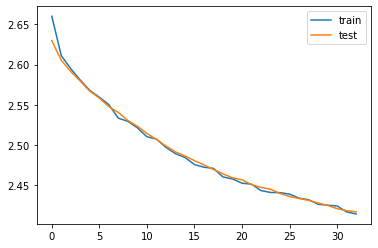

Training Loss at step 33010 : 2.482166290283203
Training Loss at step 33020 : 2.460862636566162
Training Loss at step 33030 : 2.376648426055908
Training Loss at step 33040 : 2.5281078815460205
Training Loss at step 33050 : 2.4767003059387207
Training Loss at step 33060 : 2.491062641143799
Training Loss at step 33070 : 2.4560699462890625
Training Loss at step 33080 : 2.4781882762908936
Training Loss at step 33090 : 2.417267084121704
Training Loss at step 33100 : 2.3987488746643066
Training Loss at step 33110 : 2.5289218425750732
Training Loss at step 33120 : 2.2531626224517822
Training Loss at step 33130 : 2.2164857387542725
Training Loss at step 33140 : 2.284081220626831
Training Loss at step 33150 : 2.407748222351074
Training Loss at step 33160 : 2.3358354568481445
Training Loss at step 33170 : 2.468158483505249
Training Loss at step 33180 : 2.4268360137939453
Training Loss at step 33190 : 2.1167337894439697
Training Loss at step 33200 : 2.4830455780029297
Training Loss at step 33210 

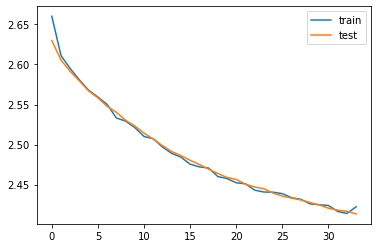

Training Loss at step 34010 : 2.4390199184417725
Training Loss at step 34020 : 2.4298148155212402
Training Loss at step 34030 : 2.4966323375701904
Training Loss at step 34040 : 2.3312947750091553
Training Loss at step 34050 : 2.449582576751709
Training Loss at step 34060 : 2.426222801208496
Training Loss at step 34070 : 2.533064365386963
Training Loss at step 34080 : 2.466219902038574
Training Loss at step 34090 : 2.388895273208618
Training Loss at step 34100 : 2.5159037113189697
Training Loss at step 34110 : 2.3028221130371094
Training Loss at step 34120 : 2.386608600616455
Training Loss at step 34130 : 2.3637242317199707
Training Loss at step 34140 : 2.2397801876068115
Training Loss at step 34150 : 2.4062559604644775
Training Loss at step 34160 : 2.282573699951172
Training Loss at step 34170 : 2.304431676864624
Training Loss at step 34180 : 2.336211919784546
Training Loss at step 34190 : 2.350536346435547
Training Loss at step 34200 : 2.3747763633728027
Training Loss at step 34210 : 

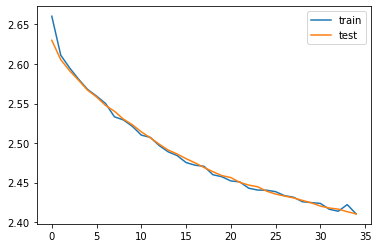

Training Loss at step 1010 : 2.4085912704467773
Training Loss at step 1020 : 2.271798610687256
Training Loss at step 1030 : 2.372772455215454
Training Loss at step 1040 : 2.2474281787872314
Training Loss at step 1050 : 2.392514705657959
Training Loss at step 1060 : 2.5323739051818848
Training Loss at step 1070 : 2.4305644035339355
Training Loss at step 1080 : 2.4328010082244873
Training Loss at step 1090 : 2.3485653400421143
Training Loss at step 1100 : 2.429290771484375
Training Loss at step 1110 : 2.224254846572876
Training Loss at step 1120 : 2.4347894191741943
Training Loss at step 1130 : 2.4695982933044434
Training Loss at step 1140 : 2.5274221897125244
Training Loss at step 1150 : 2.2772364616394043
Training Loss at step 1160 : 2.3282816410064697
Training Loss at step 1170 : 2.4357974529266357
Training Loss at step 1180 : 2.447117805480957
Training Loss at step 1190 : 2.3598315715789795
Training Loss at step 1200 : 2.572894334793091
Training Loss at step 1210 : 2.589151382446289


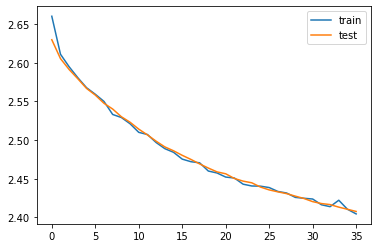

Training Loss at step 2010 : 2.364809036254883
Training Loss at step 2020 : 2.4592676162719727
Training Loss at step 2030 : 2.477555751800537
Training Loss at step 2040 : 2.369675636291504
Training Loss at step 2050 : 2.364542245864868
Training Loss at step 2060 : 2.340578079223633
Training Loss at step 2070 : 2.318187713623047
Training Loss at step 2080 : 2.3810129165649414
Training Loss at step 2090 : 2.187053918838501
Training Loss at step 2100 : 2.423565626144409
Training Loss at step 2110 : 2.4206879138946533
Training Loss at step 2120 : 2.332648277282715
Training Loss at step 2130 : 2.457127332687378
Training Loss at step 2140 : 2.4120700359344482
Training Loss at step 2150 : 2.3855414390563965
Training Loss at step 2160 : 2.565797805786133
Training Loss at step 2170 : 2.461989164352417
Training Loss at step 2180 : 2.3163859844207764
Training Loss at step 2190 : 2.3582584857940674
Training Loss at step 2200 : 2.386270046234131
Training Loss at step 2210 : 2.3120570182800293
Train

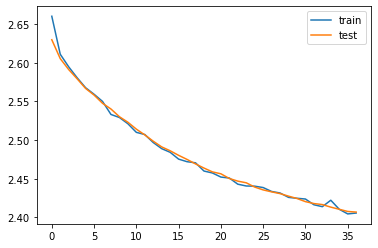

Training Loss at step 3010 : 2.248725414276123
Training Loss at step 3020 : 2.3231918811798096
Training Loss at step 3030 : 2.4437949657440186
Training Loss at step 3040 : 2.5154504776000977
Training Loss at step 3050 : 2.3960306644439697
Training Loss at step 3060 : 2.5161550045013428
Training Loss at step 3070 : 2.392601251602173
Training Loss at step 3080 : 2.447347640991211
Training Loss at step 3090 : 2.33681321144104
Training Loss at step 3100 : 2.3025031089782715
Training Loss at step 3110 : 2.3768277168273926
Training Loss at step 3120 : 2.5685386657714844
Training Loss at step 3130 : 2.330178737640381
Training Loss at step 3140 : 2.466470241546631
Training Loss at step 3150 : 2.3718037605285645
Training Loss at step 3160 : 2.366495132446289
Training Loss at step 3170 : 2.4003026485443115
Training Loss at step 3180 : 2.4622392654418945
Training Loss at step 3190 : 2.338829755783081
Training Loss at step 3200 : 2.2868010997772217
Training Loss at step 3210 : 2.431778907775879
Tr

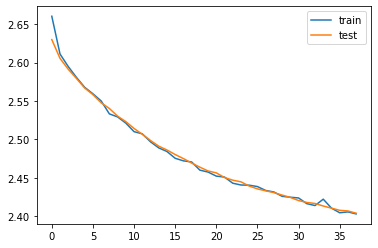

Training Loss at step 4010 : 2.271836042404175
Training Loss at step 4020 : 2.392195224761963
Training Loss at step 4030 : 2.4936771392822266
Training Loss at step 4040 : 2.446890354156494
Training Loss at step 4050 : 2.480173110961914
Training Loss at step 4060 : 2.5606555938720703
Training Loss at step 4070 : 2.357191324234009
Training Loss at step 4080 : 2.340989351272583
Training Loss at step 4090 : 2.422048330307007
Training Loss at step 4100 : 2.4822254180908203
Training Loss at step 4110 : 2.4767651557922363
Training Loss at step 4120 : 2.1144886016845703
Training Loss at step 4130 : 2.417280912399292
Training Loss at step 4140 : 2.389849901199341
Training Loss at step 4150 : 2.326167106628418
Training Loss at step 4160 : 2.444659948348999
Training Loss at step 4170 : 2.389261245727539
Training Loss at step 4180 : 2.396252155303955
Training Loss at step 4190 : 2.4443202018737793
Training Loss at step 4200 : 2.471475839614868
Training Loss at step 4210 : 2.4541120529174805
Traini

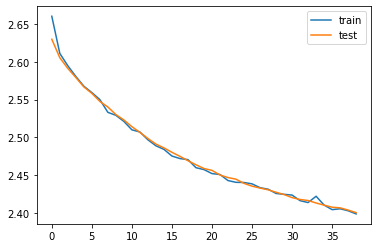

Training Loss at step 5010 : 2.372588872909546
Training Loss at step 5020 : 2.4627914428710938
Training Loss at step 5030 : 2.3628928661346436
Training Loss at step 5040 : 2.3759262561798096
Training Loss at step 5050 : 2.5629525184631348
Training Loss at step 5060 : 2.4728314876556396
Training Loss at step 5070 : 2.469090223312378
Training Loss at step 5080 : 2.4658491611480713
Training Loss at step 5090 : 2.527498722076416
Training Loss at step 5100 : 2.425875425338745
Training Loss at step 5110 : 2.4551138877868652
Training Loss at step 5120 : 2.3684403896331787
Training Loss at step 5130 : 2.3509411811828613
Training Loss at step 5140 : 2.3208580017089844
Training Loss at step 5150 : 2.3782944679260254
Training Loss at step 5160 : 2.407158851623535
Training Loss at step 5170 : 2.4505395889282227
Training Loss at step 5180 : 2.4955947399139404
Training Loss at step 5190 : 2.361077308654785
Training Loss at step 5200 : 2.585026741027832
Training Loss at step 5210 : 2.363934278488159


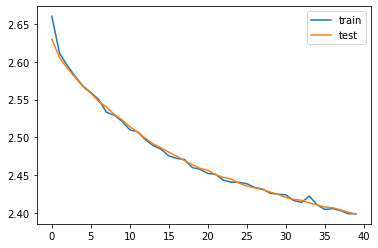

Training Loss at step 6010 : 2.4230592250823975
Training Loss at step 6020 : 2.4618961811065674
Training Loss at step 6030 : 2.359243631362915
Training Loss at step 6040 : 2.3898258209228516
Training Loss at step 6050 : 2.409027099609375
Training Loss at step 6060 : 2.436657190322876
Training Loss at step 6070 : 2.34041690826416
Training Loss at step 6080 : 2.3833556175231934
Training Loss at step 6090 : 2.510925531387329
Training Loss at step 6100 : 2.564473867416382
Training Loss at step 6110 : 2.2383463382720947
Training Loss at step 6120 : 2.4832842350006104
Training Loss at step 6130 : 2.45599102973938
Training Loss at step 6140 : 2.2723467350006104
Training Loss at step 6150 : 2.3546717166900635
Training Loss at step 6160 : 2.2268476486206055
Training Loss at step 6170 : 2.474775791168213
Training Loss at step 6180 : 2.287020206451416
Training Loss at step 6190 : 2.4311368465423584
Training Loss at step 6200 : 2.51778244972229
Training Loss at step 6210 : 2.4933457374572754
Train

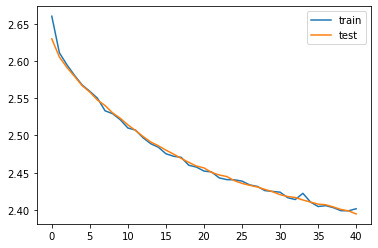

Training Loss at step 7010 : 2.4290757179260254
Training Loss at step 7020 : 2.628192901611328
Training Loss at step 7030 : 2.284269332885742
Training Loss at step 7040 : 2.480694532394409
Training Loss at step 7050 : 2.3333334922790527
Training Loss at step 7060 : 2.2477502822875977
Training Loss at step 7070 : 2.389112710952759
Training Loss at step 7080 : 2.5291218757629395
Training Loss at step 7090 : 2.49823260307312
Training Loss at step 7100 : 2.448194980621338
Training Loss at step 7110 : 2.1849703788757324
Training Loss at step 7120 : 2.466381072998047
Training Loss at step 7130 : 2.5037169456481934
Training Loss at step 7140 : 2.422607421875
Training Loss at step 7150 : 2.2922184467315674
Training Loss at step 7160 : 2.393854856491089
Training Loss at step 7170 : 2.4855239391326904
Training Loss at step 7180 : 2.446580410003662
Training Loss at step 7190 : 2.5021541118621826
Training Loss at step 7200 : 2.5269031524658203
Training Loss at step 7210 : 2.49851393699646
Training

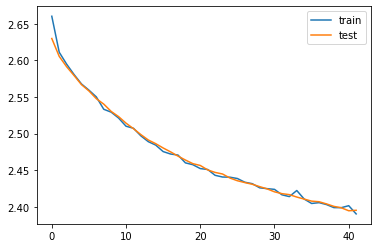

Training Loss at step 8010 : 2.332578182220459
Training Loss at step 8020 : 2.3235130310058594
Training Loss at step 8030 : 2.328219413757324
Training Loss at step 8040 : 2.373349189758301
Training Loss at step 8050 : 2.452580451965332
Training Loss at step 8060 : 2.440906524658203
Training Loss at step 8070 : 2.383294105529785
Training Loss at step 8080 : 2.4019980430603027
Training Loss at step 8090 : 2.409052848815918
Training Loss at step 8100 : 2.2630927562713623
Training Loss at step 8110 : 2.222120523452759
Training Loss at step 8120 : 2.4673879146575928
Training Loss at step 8130 : 2.40236759185791
Training Loss at step 8140 : 2.4383668899536133
Training Loss at step 8150 : 2.425124168395996
Training Loss at step 8160 : 2.4647042751312256
Training Loss at step 8170 : 2.4510624408721924
Training Loss at step 8180 : 2.256694793701172
Training Loss at step 8190 : 2.469449758529663
Training Loss at step 8200 : 2.4914908409118652
Training Loss at step 8210 : 2.3921101093292236
Train

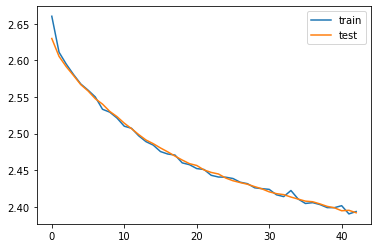

Training Loss at step 9010 : 2.3836965560913086
Training Loss at step 9020 : 2.4620118141174316
Training Loss at step 9030 : 2.4170830249786377
Training Loss at step 9040 : 2.387327194213867
Training Loss at step 9050 : 2.4485015869140625
Training Loss at step 9060 : 2.40926456451416
Training Loss at step 9070 : 2.5370869636535645
Training Loss at step 9080 : 2.474794626235962
Training Loss at step 9090 : 2.5650479793548584
Training Loss at step 9100 : 2.485128402709961
Training Loss at step 9110 : 2.3174428939819336
Training Loss at step 9120 : 2.3811094760894775
Training Loss at step 9130 : 2.2951369285583496
Training Loss at step 9140 : 2.3760604858398438
Training Loss at step 9150 : 2.3790338039398193
Training Loss at step 9160 : 2.390613079071045
Training Loss at step 9170 : 2.400606393814087
Training Loss at step 9180 : 2.3282408714294434
Training Loss at step 9190 : 2.399137020111084
Training Loss at step 9200 : 2.2296018600463867
Training Loss at step 9210 : 2.3537590503692627


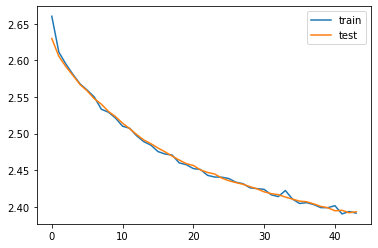

Training Loss at step 10010 : 2.3896090984344482
Training Loss at step 10020 : 2.596808910369873
Training Loss at step 10030 : 2.518096685409546
Training Loss at step 10040 : 2.407158374786377
Training Loss at step 10050 : 2.277780055999756
Training Loss at step 10060 : 2.1845123767852783
Training Loss at step 10070 : 2.424098491668701
Training Loss at step 10080 : 2.3713510036468506
Training Loss at step 10090 : 2.265580654144287
Training Loss at step 10100 : 2.1999897956848145
Training Loss at step 10110 : 2.413649559020996
Training Loss at step 10120 : 2.302417755126953
Training Loss at step 10130 : 2.469066619873047
Training Loss at step 10140 : 2.271129846572876
Training Loss at step 10150 : 2.2420032024383545
Training Loss at step 10160 : 2.3384933471679688
Training Loss at step 10170 : 2.392789363861084
Training Loss at step 10180 : 2.3739211559295654
Training Loss at step 10190 : 2.506772994995117
Training Loss at step 10200 : 2.2902004718780518
Training Loss at step 10210 : 2.

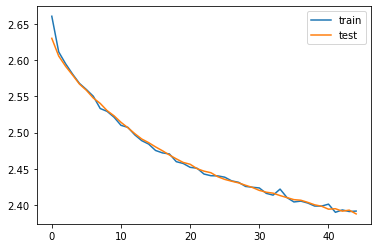

Training Loss at step 11010 : 2.5087854862213135
Training Loss at step 11020 : 2.3580148220062256
Training Loss at step 11030 : 2.342970132827759
Training Loss at step 11040 : 2.300788402557373
Training Loss at step 11050 : 2.53202486038208
Training Loss at step 11060 : 2.3139100074768066
Training Loss at step 11070 : 2.3740365505218506
Training Loss at step 11080 : 2.4179694652557373
Training Loss at step 11090 : 2.50100040435791
Training Loss at step 11100 : 2.483701229095459
Training Loss at step 11110 : 2.3167669773101807
Training Loss at step 11120 : 2.5433759689331055
Training Loss at step 11130 : 2.3864080905914307
Training Loss at step 11140 : 2.4313526153564453
Training Loss at step 11150 : 2.453784227371216
Training Loss at step 11160 : 2.4221906661987305
Training Loss at step 11170 : 2.345348834991455
Training Loss at step 11180 : 2.414154052734375
Training Loss at step 11190 : 2.4456074237823486
Training Loss at step 11200 : 2.597282886505127
Training Loss at step 11210 : 2

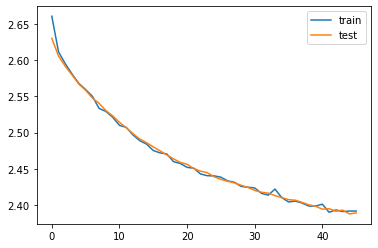

Training Loss at step 12010 : 2.581179618835449
Training Loss at step 12020 : 2.526399612426758
Training Loss at step 12030 : 2.2935242652893066
Training Loss at step 12040 : 2.391695261001587
Training Loss at step 12050 : 2.340775966644287
Training Loss at step 12060 : 2.3379602432250977
Training Loss at step 12070 : 2.1980230808258057
Training Loss at step 12080 : 2.411632537841797
Training Loss at step 12090 : 2.524324417114258
Training Loss at step 12100 : 2.469862937927246
Training Loss at step 12110 : 2.2904953956604004
Training Loss at step 12120 : 2.3664944171905518
Training Loss at step 12130 : 2.3415472507476807
Training Loss at step 12140 : 2.336744546890259
Training Loss at step 12150 : 2.348295211791992
Training Loss at step 12160 : 2.1306424140930176
Training Loss at step 12170 : 2.3777976036071777
Training Loss at step 12180 : 2.398082733154297
Training Loss at step 12190 : 2.4788291454315186
Training Loss at step 12200 : 2.359187602996826
Training Loss at step 12210 : 2

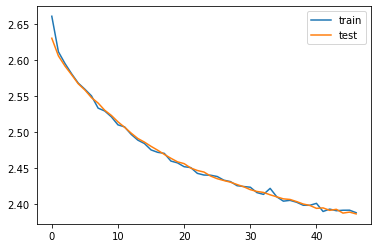

Training Loss at step 13010 : 2.2787492275238037
Training Loss at step 13020 : 2.4245221614837646
Training Loss at step 13030 : 2.441448450088501
Training Loss at step 13040 : 2.458648681640625
Training Loss at step 13050 : 2.4365968704223633
Training Loss at step 13060 : 2.374885082244873
Training Loss at step 13070 : 2.4908270835876465
Training Loss at step 13080 : 2.3209242820739746
Training Loss at step 13090 : 2.358713388442993
Training Loss at step 13100 : 2.3796658515930176
Training Loss at step 13110 : 2.369152545928955
Training Loss at step 13120 : 2.4935145378112793
Training Loss at step 13130 : 2.4872195720672607
Training Loss at step 13140 : 2.3316566944122314
Training Loss at step 13150 : 2.3963470458984375
Training Loss at step 13160 : 2.2342560291290283
Training Loss at step 13170 : 2.3146026134490967
Training Loss at step 13180 : 2.323340892791748
Training Loss at step 13190 : 2.4431991577148438
Training Loss at step 13200 : 2.3010621070861816
Training Loss at step 1321

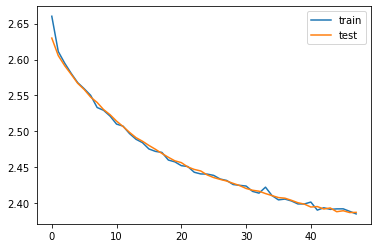

Training Loss at step 14010 : 2.39772891998291
Training Loss at step 14020 : 2.4904422760009766
Training Loss at step 14030 : 2.231282949447632
Training Loss at step 14040 : 2.480560064315796
Training Loss at step 14050 : 2.368241786956787
Training Loss at step 14060 : 2.2870304584503174
Training Loss at step 14070 : 2.307053327560425
Training Loss at step 14080 : 2.3997161388397217
Training Loss at step 14090 : 2.454596996307373
Training Loss at step 14100 : 2.3651816844940186
Training Loss at step 14110 : 2.402503252029419
Training Loss at step 14120 : 2.4339027404785156
Training Loss at step 14130 : 2.4676382541656494
Training Loss at step 14140 : 2.0933802127838135
Training Loss at step 14150 : 2.4100656509399414
Training Loss at step 14160 : 2.4012210369110107
Training Loss at step 14170 : 2.3387889862060547
Training Loss at step 14180 : 2.447685718536377
Training Loss at step 14190 : 2.2423408031463623
Training Loss at step 14200 : 2.3060100078582764
Training Loss at step 14210 :

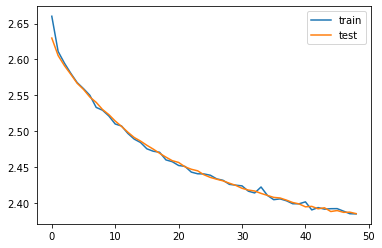

Training Loss at step 15010 : 2.3557465076446533
Training Loss at step 15020 : 2.4045870304107666
Training Loss at step 15030 : 2.5136423110961914
Training Loss at step 15040 : 2.3578031063079834
Training Loss at step 15050 : 2.4695234298706055
Training Loss at step 15060 : 2.2936301231384277
Training Loss at step 15070 : 2.250976800918579
Training Loss at step 15080 : 2.3870275020599365
Training Loss at step 15090 : 2.4615941047668457
Training Loss at step 15100 : 2.3889830112457275
Training Loss at step 15110 : 2.213724374771118
Training Loss at step 15120 : 2.4169044494628906
Training Loss at step 15130 : 2.402874231338501
Training Loss at step 15140 : 2.340838670730591
Training Loss at step 15150 : 2.3515796661376953
Training Loss at step 15160 : 2.229426622390747
Training Loss at step 15170 : 2.374767303466797
Training Loss at step 15180 : 2.3920273780822754
Training Loss at step 15190 : 2.447909355163574
Training Loss at step 15200 : 2.2808899879455566
Training Loss at step 15210

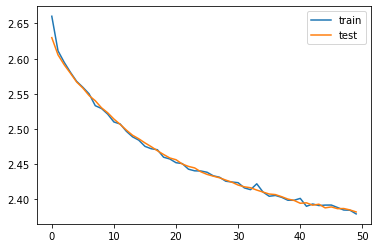

Training Loss at step 16010 : 2.495126962661743
Training Loss at step 16020 : 2.3430092334747314
Training Loss at step 16030 : 2.3926408290863037
Training Loss at step 16040 : 2.565355062484741
Training Loss at step 16050 : 2.404658317565918
Training Loss at step 16060 : 2.3314566612243652
Training Loss at step 16070 : 2.3316469192504883
Training Loss at step 16080 : 2.512634515762329
Training Loss at step 16090 : 2.3526148796081543
Training Loss at step 16100 : 2.4000959396362305
Training Loss at step 16110 : 2.210036516189575
Training Loss at step 16120 : 2.4566967487335205
Training Loss at step 16130 : 2.3903605937957764
Training Loss at step 16140 : 2.5324010848999023
Training Loss at step 16150 : 2.5113422870635986
Training Loss at step 16160 : 2.3640878200531006
Training Loss at step 16170 : 2.451488971710205
Training Loss at step 16180 : 2.406883716583252
Training Loss at step 16190 : 2.341947555541992
Training Loss at step 16200 : 2.452014446258545
Training Loss at step 16210 :

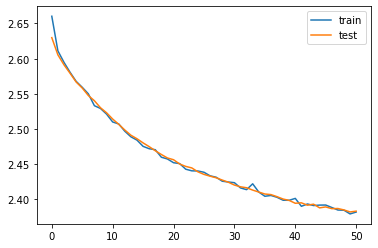

Training Loss at step 17010 : 2.3987276554107666
Training Loss at step 17020 : 2.460336923599243
Training Loss at step 17030 : 2.340852975845337
Training Loss at step 17040 : 2.350919008255005
Training Loss at step 17050 : 2.3243658542633057
Training Loss at step 17060 : 2.5495805740356445
Training Loss at step 17070 : 2.2183237075805664
Training Loss at step 17080 : 2.417869806289673
Training Loss at step 17090 : 2.301407814025879
Training Loss at step 17100 : 2.391510248184204
Training Loss at step 17110 : 2.396888017654419
Training Loss at step 17120 : 2.3115081787109375
Training Loss at step 17130 : 2.257838249206543
Training Loss at step 17140 : 2.147308349609375
Training Loss at step 17150 : 2.3834733963012695
Training Loss at step 17160 : 2.425698757171631
Training Loss at step 17170 : 2.361956834793091
Training Loss at step 17180 : 2.355450391769409
Training Loss at step 17190 : 2.276496648788452
Training Loss at step 17200 : 2.462283134460449
Training Loss at step 17210 : 2.48

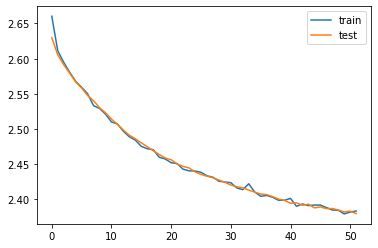

Training Loss at step 18010 : 2.4550633430480957
Training Loss at step 18020 : 2.324444055557251
Training Loss at step 18030 : 2.4902567863464355
Training Loss at step 18040 : 2.3442330360412598
Training Loss at step 18050 : 2.4381353855133057
Training Loss at step 18060 : 2.4256861209869385
Training Loss at step 18070 : 2.3791894912719727
Training Loss at step 18080 : 2.3133902549743652
Training Loss at step 18090 : 2.2927842140197754
Training Loss at step 18100 : 2.3289685249328613
Training Loss at step 18110 : 2.515146017074585
Training Loss at step 18120 : 2.431337356567383
Training Loss at step 18130 : 2.245657444000244
Training Loss at step 18140 : 2.230705499649048
Training Loss at step 18150 : 2.437321186065674
Training Loss at step 18160 : 2.22841215133667
Training Loss at step 18170 : 2.376025438308716
Training Loss at step 18180 : 2.2090773582458496
Training Loss at step 18190 : 2.273324728012085
Training Loss at step 18200 : 2.4201223850250244
Training Loss at step 18210 : 

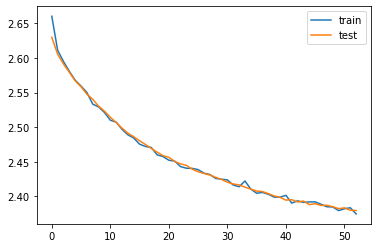

Training Loss at step 19010 : 2.464684247970581
Training Loss at step 19020 : 2.4682538509368896
Training Loss at step 19030 : 2.307349443435669
Training Loss at step 19040 : 2.3647549152374268
Training Loss at step 19050 : 2.2641472816467285
Training Loss at step 19060 : 2.463529586791992
Training Loss at step 19070 : 2.138425350189209
Training Loss at step 19080 : 2.2222495079040527
Training Loss at step 19090 : 2.3544769287109375
Training Loss at step 19100 : 2.5241410732269287
Training Loss at step 19110 : 2.5359928607940674
Training Loss at step 19120 : 2.299837589263916
Training Loss at step 19130 : 2.3004794120788574
Training Loss at step 19140 : 2.392432451248169
Training Loss at step 19150 : 2.439528226852417
Training Loss at step 19160 : 2.4891750812530518
Training Loss at step 19170 : 2.2772459983825684
Training Loss at step 19180 : 2.4240097999572754
Training Loss at step 19190 : 2.3489978313446045
Training Loss at step 19200 : 2.3013923168182373
Training Loss at step 19210

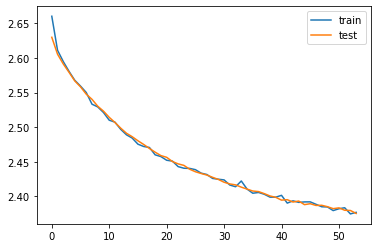

Training Loss at step 20010 : 2.3550639152526855
Training Loss at step 20020 : 2.4590163230895996
Training Loss at step 20030 : 2.42581844329834
Training Loss at step 20040 : 2.393599271774292
Training Loss at step 20050 : 2.421393871307373
Training Loss at step 20060 : 2.3778626918792725
Training Loss at step 20070 : 2.289889097213745
Training Loss at step 20080 : 2.351942300796509
Training Loss at step 20090 : 2.2688400745391846
Training Loss at step 20100 : 2.4338228702545166
Training Loss at step 20110 : 2.3845016956329346
Training Loss at step 20120 : 2.4154984951019287
Training Loss at step 20130 : 2.25754714012146
Training Loss at step 20140 : 2.249488592147827
Training Loss at step 20150 : 2.398747682571411
Training Loss at step 20160 : 2.2968697547912598
Training Loss at step 20170 : 2.4164605140686035
Training Loss at step 20180 : 2.4730725288391113
Training Loss at step 20190 : 2.270792245864868
Training Loss at step 20200 : 2.4250733852386475
Training Loss at step 20210 : 2

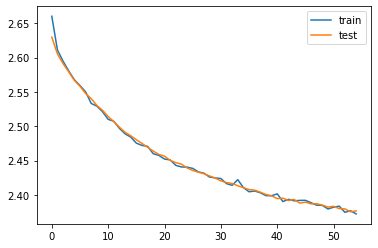

Training Loss at step 21010 : 2.4839532375335693
Training Loss at step 21020 : 2.4730701446533203
Training Loss at step 21030 : 2.4268338680267334
Training Loss at step 21040 : 2.591895818710327
Training Loss at step 21050 : 2.476809501647949
Training Loss at step 21060 : 2.3587894439697266
Training Loss at step 21070 : 2.4424092769622803
Training Loss at step 21080 : 2.503535032272339
Training Loss at step 21090 : 2.266711950302124
Training Loss at step 21100 : 2.4907758235931396
Training Loss at step 21110 : 2.4394798278808594
Training Loss at step 21120 : 2.5733606815338135
Training Loss at step 21130 : 2.3606956005096436
Training Loss at step 21140 : 2.3418259620666504
Training Loss at step 21150 : 2.405395984649658
Training Loss at step 21160 : 2.5118699073791504
Training Loss at step 21170 : 2.283074378967285
Training Loss at step 21180 : 2.3269078731536865
Training Loss at step 21190 : 2.385624647140503
Training Loss at step 21200 : 2.3501200675964355
Training Loss at step 21210

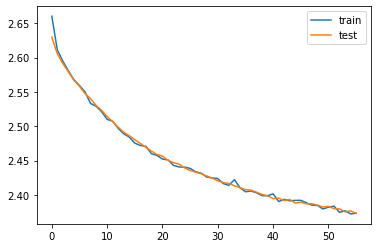

Training Loss at step 22010 : 2.337385654449463
Training Loss at step 22020 : 2.5296316146850586
Training Loss at step 22030 : 2.3305962085723877
Training Loss at step 22040 : 2.3647944927215576
Training Loss at step 22050 : 2.468902587890625
Training Loss at step 22060 : 2.4217333793640137
Training Loss at step 22070 : 2.2682878971099854
Training Loss at step 22080 : 2.4679033756256104
Training Loss at step 22090 : 2.52209734916687
Training Loss at step 22100 : 2.3588149547576904
Training Loss at step 22110 : 2.4635024070739746
Training Loss at step 22120 : 2.266510486602783
Training Loss at step 22130 : 2.3125245571136475
Training Loss at step 22140 : 2.4282302856445312
Training Loss at step 22150 : 2.455834150314331
Training Loss at step 22160 : 2.4290971755981445
Training Loss at step 22170 : 2.136486530303955
Training Loss at step 22180 : 2.3456432819366455
Training Loss at step 22190 : 2.300497531890869
Training Loss at step 22200 : 2.36116623878479
Training Loss at step 22210 : 

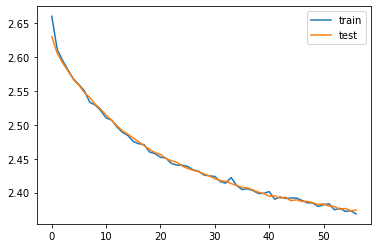

Training Loss at step 23010 : 2.4054949283599854
Training Loss at step 23020 : 2.529515266418457
Training Loss at step 23030 : 2.4476006031036377
Training Loss at step 23040 : 2.3463988304138184
Training Loss at step 23050 : 2.2701194286346436
Training Loss at step 23060 : 2.3891847133636475
Training Loss at step 23070 : 2.3740110397338867
Training Loss at step 23080 : 2.339055061340332
Training Loss at step 23090 : 2.2819528579711914
Training Loss at step 23100 : 2.4544498920440674
Training Loss at step 23110 : 2.2763640880584717
Training Loss at step 23120 : 2.344609022140503
Training Loss at step 23130 : 2.4269065856933594
Training Loss at step 23140 : 2.338507652282715
Training Loss at step 23150 : 2.506669521331787
Training Loss at step 23160 : 2.289907455444336
Training Loss at step 23170 : 2.265651226043701
Training Loss at step 23180 : 2.346541166305542
Training Loss at step 23190 : 2.31544828414917
Training Loss at step 23200 : 2.397728204727173
Training Loss at step 23210 : 2

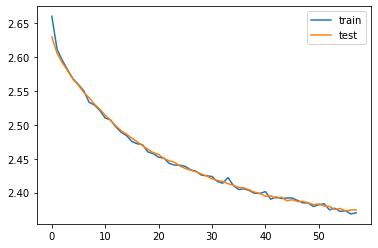

Training Loss at step 24010 : 2.639462471008301
Training Loss at step 24020 : 2.4606568813323975
Training Loss at step 24030 : 2.3458805084228516
Training Loss at step 24040 : 2.3050029277801514
Training Loss at step 24050 : 2.430631637573242
Training Loss at step 24060 : 2.420154571533203
Training Loss at step 24070 : 2.3490490913391113
Training Loss at step 24080 : 2.431725025177002
Training Loss at step 24090 : 2.4826509952545166
Training Loss at step 24100 : 2.303267478942871
Training Loss at step 24110 : 2.3143181800842285
Training Loss at step 24120 : 2.341414451599121
Training Loss at step 24130 : 2.431386947631836
Training Loss at step 24140 : 2.316650867462158
Training Loss at step 24150 : 2.2564711570739746
Training Loss at step 24160 : 2.5840158462524414
Training Loss at step 24170 : 2.398672342300415
Training Loss at step 24180 : 2.2830429077148438
Training Loss at step 24190 : 2.4021434783935547
Training Loss at step 24200 : 2.2230050563812256
Training Loss at step 24210 :

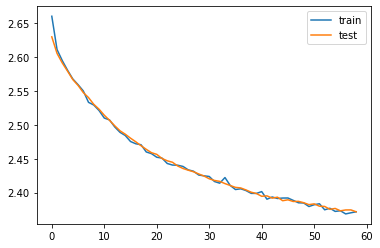

Training Loss at step 25010 : 2.374208927154541
Training Loss at step 25020 : 2.369515895843506
Training Loss at step 25030 : 2.299382448196411
Training Loss at step 25040 : 2.4982683658599854
Training Loss at step 25050 : 2.4262986183166504
Training Loss at step 25060 : 2.473083019256592
Training Loss at step 25070 : 2.475999355316162
Training Loss at step 25080 : 2.387547254562378
Training Loss at step 25090 : 2.4657249450683594
Training Loss at step 25100 : 2.404440402984619
Training Loss at step 25110 : 2.49326753616333
Training Loss at step 25120 : 2.3149003982543945
Training Loss at step 25130 : 2.3454973697662354
Training Loss at step 25140 : 2.586230516433716
Training Loss at step 25150 : 2.4422223567962646
Training Loss at step 25160 : 2.3312087059020996
Training Loss at step 25170 : 2.427783966064453
Training Loss at step 25180 : 2.277935266494751
Training Loss at step 25190 : 2.4557461738586426
Training Loss at step 25200 : 2.4152703285217285
Training Loss at step 25210 : 2.

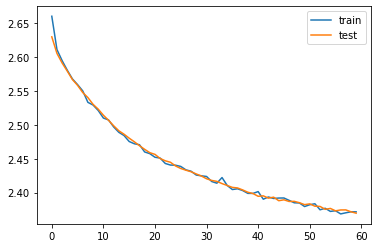

Training Loss at step 26010 : 2.3358969688415527
Training Loss at step 26020 : 2.3600051403045654
Training Loss at step 26030 : 2.2861671447753906
Training Loss at step 26040 : 2.5036561489105225
Training Loss at step 26050 : 2.3865127563476562
Training Loss at step 26060 : 2.276289939880371
Training Loss at step 26070 : 2.3503053188323975
Training Loss at step 26080 : 2.3670449256896973
Training Loss at step 26090 : 2.2764930725097656
Training Loss at step 26100 : 2.319525718688965
Training Loss at step 26110 : 2.526829957962036
Training Loss at step 26120 : 2.2685396671295166
Training Loss at step 26130 : 2.4655916690826416
Training Loss at step 26140 : 2.440147638320923
Training Loss at step 26150 : 2.3884146213531494
Training Loss at step 26160 : 2.2648372650146484
Training Loss at step 26170 : 2.4079627990722656
Training Loss at step 26180 : 2.3972482681274414
Training Loss at step 26190 : 2.364011526107788
Training Loss at step 26200 : 2.5181334018707275
Training Loss at step 262

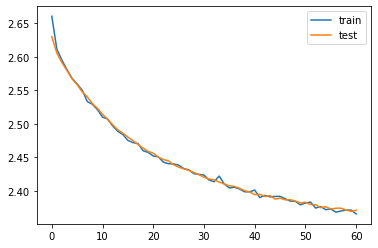

Training Loss at step 27010 : 2.254854202270508
Training Loss at step 27020 : 2.520968437194824
Training Loss at step 27030 : 2.375699043273926
Training Loss at step 27040 : 2.320997953414917
Training Loss at step 27050 : 2.300886631011963
Training Loss at step 27060 : 2.2881999015808105
Training Loss at step 27070 : 2.3932888507843018
Training Loss at step 27080 : 2.280510425567627
Training Loss at step 27090 : 2.5630276203155518
Training Loss at step 27100 : 2.3368074893951416
Training Loss at step 27110 : 2.288583517074585
Training Loss at step 27120 : 2.3327646255493164
Training Loss at step 27130 : 2.3667361736297607
Training Loss at step 27140 : 2.25502347946167
Training Loss at step 27150 : 2.4045143127441406
Training Loss at step 27160 : 2.466510534286499
Training Loss at step 27170 : 2.2425107955932617
Training Loss at step 27180 : 2.3785059452056885
Training Loss at step 27190 : 2.3555209636688232
Training Loss at step 27200 : 2.5174312591552734
Training Loss at step 27210 : 

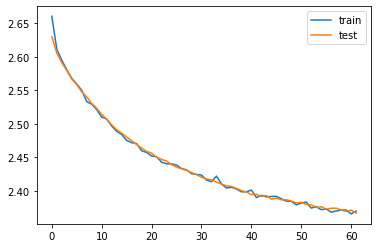

Training Loss at step 28010 : 2.333061456680298
Training Loss at step 28020 : 2.4236223697662354
Training Loss at step 28030 : 2.2197749614715576
Training Loss at step 28040 : 2.2130913734436035
Training Loss at step 28050 : 2.3336946964263916
Training Loss at step 28060 : 2.307982921600342
Training Loss at step 28070 : 2.5047876834869385
Training Loss at step 28080 : 2.4195849895477295
Training Loss at step 28090 : 2.442460060119629
Training Loss at step 28100 : 2.3817012310028076
Training Loss at step 28110 : 2.451296091079712
Training Loss at step 28120 : 2.308636426925659
Training Loss at step 28130 : 2.4088752269744873
Training Loss at step 28140 : 2.474404811859131
Training Loss at step 28150 : 2.4517695903778076
Training Loss at step 28160 : 2.249605655670166
Training Loss at step 28170 : 2.37548565864563
Training Loss at step 28180 : 2.3113975524902344
Training Loss at step 28190 : 2.432926893234253
Training Loss at step 28200 : 2.4535574913024902
Training Loss at step 28210 : 

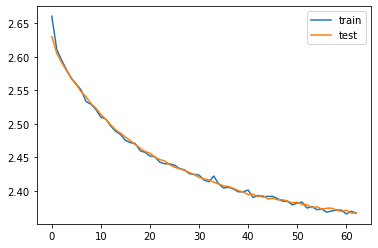

Training Loss at step 29010 : 2.499333143234253
Training Loss at step 29020 : 2.466867208480835
Training Loss at step 29030 : 2.506033420562744
Training Loss at step 29040 : 2.4208712577819824
Training Loss at step 29050 : 2.409123182296753
Training Loss at step 29060 : 2.268002510070801
Training Loss at step 29070 : 2.381404161453247
Training Loss at step 29080 : 2.2729787826538086
Training Loss at step 29090 : 2.4502124786376953
Training Loss at step 29100 : 2.3205549716949463
Training Loss at step 29110 : 2.318007707595825
Training Loss at step 29120 : 2.4177234172821045
Training Loss at step 29130 : 2.458160638809204
Training Loss at step 29140 : 2.36818790435791
Training Loss at step 29150 : 2.38139009475708
Training Loss at step 29160 : 2.4578118324279785
Training Loss at step 29170 : 2.250068426132202
Training Loss at step 29180 : 2.3439433574676514
Training Loss at step 29190 : 2.40387225151062
Training Loss at step 29200 : 2.382065534591675
Training Loss at step 29210 : 2.3553

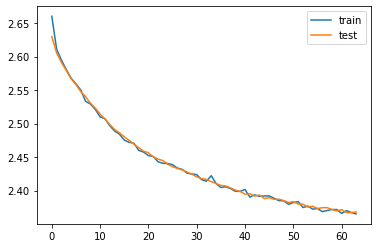

Training Loss at step 30010 : 2.2701454162597656
Training Loss at step 30020 : 2.489966630935669
Training Loss at step 30030 : 2.260138750076294
Training Loss at step 30040 : 2.372921943664551
Training Loss at step 30050 : 2.4622535705566406
Training Loss at step 30060 : 2.28997802734375
Training Loss at step 30070 : 2.335895538330078
Training Loss at step 30080 : 2.464468240737915
Training Loss at step 30090 : 2.367164134979248
Training Loss at step 30100 : 2.412458896636963
Training Loss at step 30110 : 2.5640971660614014
Training Loss at step 30120 : 2.370950698852539
Training Loss at step 30130 : 2.376817226409912
Training Loss at step 30140 : 2.3580048084259033
Training Loss at step 30150 : 2.423309803009033
Training Loss at step 30160 : 2.2215921878814697
Training Loss at step 30170 : 2.256272077560425
Training Loss at step 30180 : 2.3536200523376465
Training Loss at step 30190 : 2.4920685291290283
Training Loss at step 30200 : 2.4555416107177734
Training Loss at step 30210 : 2.3

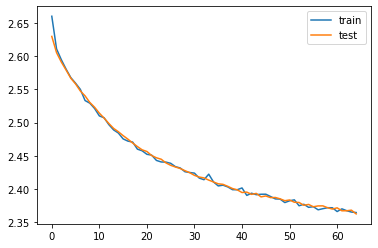

Training Loss at step 31010 : 2.2776498794555664
Training Loss at step 31020 : 2.388200283050537
Training Loss at step 31030 : 2.385619878768921
Training Loss at step 31040 : 2.431058168411255
Training Loss at step 31050 : 2.2941274642944336
Training Loss at step 31060 : 2.2396581172943115
Training Loss at step 31070 : 2.357625961303711
Training Loss at step 31080 : 2.2780232429504395
Training Loss at step 31090 : 2.367387533187866
Training Loss at step 31100 : 2.351367473602295
Training Loss at step 31110 : 2.317056655883789
Training Loss at step 31120 : 2.442564010620117
Training Loss at step 31130 : 2.179504156112671
Training Loss at step 31140 : 2.426651954650879
Training Loss at step 31150 : 2.3612165451049805
Training Loss at step 31160 : 2.4211437702178955
Training Loss at step 31170 : 2.3179588317871094
Training Loss at step 31180 : 2.2753336429595947
Training Loss at step 31190 : 2.2203218936920166
Training Loss at step 31200 : 2.380854845046997
Training Loss at step 31210 : 2

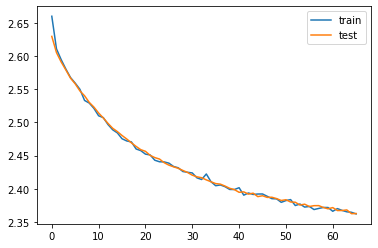

Training Loss at step 32010 : 2.3073537349700928
Training Loss at step 32020 : 2.3197450637817383
Training Loss at step 32030 : 2.294753074645996
Training Loss at step 32040 : 2.4231667518615723
Training Loss at step 32050 : 2.3147897720336914
Training Loss at step 32060 : 2.4417166709899902
Training Loss at step 32070 : 2.3914294242858887
Training Loss at step 32080 : 2.3257946968078613
Training Loss at step 32090 : 2.4112460613250732
Training Loss at step 32100 : 2.46805477142334
Training Loss at step 32110 : 2.3470964431762695
Training Loss at step 32120 : 2.354506492614746
Training Loss at step 32130 : 2.410959005355835
Training Loss at step 32140 : 2.4688925743103027
Training Loss at step 32150 : 2.487550973892212
Training Loss at step 32160 : 2.37843918800354
Training Loss at step 32170 : 2.410231828689575
Training Loss at step 32180 : 2.337934732437134
Training Loss at step 32190 : 2.387542486190796
Training Loss at step 32200 : 2.363375186920166
Training Loss at step 32210 : 2.

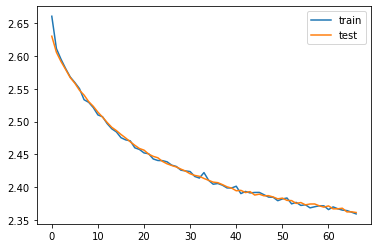

Training Loss at step 33010 : 2.413198709487915
Training Loss at step 33020 : 2.430262327194214
Training Loss at step 33030 : 2.370814800262451
Training Loss at step 33040 : 2.4875948429107666
Training Loss at step 33050 : 2.352220296859741
Training Loss at step 33060 : 2.4355661869049072
Training Loss at step 33070 : 2.3564722537994385
Training Loss at step 33080 : 2.4606785774230957
Training Loss at step 33090 : 2.287104845046997
Training Loss at step 33100 : 2.3907175064086914
Training Loss at step 33110 : 2.48978853225708
Training Loss at step 33120 : 2.155761480331421
Training Loss at step 33130 : 2.148303508758545
Training Loss at step 33140 : 2.26363205909729
Training Loss at step 33150 : 2.2957842350006104
Training Loss at step 33160 : 2.3106343746185303
Training Loss at step 33170 : 2.4480788707733154
Training Loss at step 33180 : 2.3175041675567627
Training Loss at step 33190 : 2.0442118644714355
Training Loss at step 33200 : 2.473783254623413
Training Loss at step 33210 : 2.

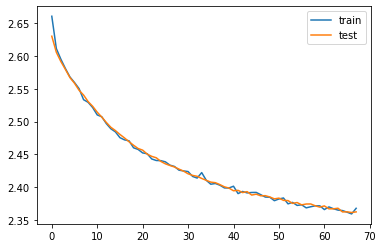

Training Loss at step 34010 : 2.420166015625
Training Loss at step 34020 : 2.3897616863250732
Training Loss at step 34030 : 2.4543440341949463
Training Loss at step 34040 : 2.294307231903076
Training Loss at step 34050 : 2.417005777359009
Training Loss at step 34060 : 2.4072866439819336
Training Loss at step 34070 : 2.479949474334717
Training Loss at step 34080 : 2.360238552093506
Training Loss at step 34090 : 2.3520100116729736
Training Loss at step 34100 : 2.425379514694214
Training Loss at step 34110 : 2.2570831775665283
Training Loss at step 34120 : 2.3349099159240723
Training Loss at step 34130 : 2.317298412322998
Training Loss at step 34140 : 2.1545403003692627
Training Loss at step 34150 : 2.3342976570129395
Training Loss at step 34160 : 2.288306951522827
Training Loss at step 34170 : 2.2561192512512207
Training Loss at step 34180 : 2.2604830265045166
Training Loss at step 34190 : 2.34541392326355
Training Loss at step 34200 : 2.3590593338012695
Training Loss at step 34210 : 2.4

In [18]:
model = FullContextSpanClassifier(labels).to(device)
model.train()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

t1 = time.time()

train_losses_per_test = []
test_losses = []

for epoch in range(n_epochs):
    batch_losses = []
    for step in range(len(train_x_batches)):
        
        batch_losses.append(train_model_on_batch(model, train_x_batches[step], train_y_batches[step], optimizer, articles, only_spans, tokenizer, device, report_loss=step%10==0))
        
        if step % batches_before_test == 0 and step > 0:
            train_losses_per_test.append(sum(batch_losses)/len(batch_losses))
            batch_losses = []
            test_loss,preds = test_model(model, tokenizer, test_x_batches, test_y_batches, articles, only_spans, device, loss_fn)
            test_losses.append(test_loss)
            plot_losses(train_losses_per_test, test_losses)
            
    #after each epoch, save model checkpoint...
    torch.save(model.state_dict(), "./roberta-mfc-no-context-ce-loss-epoch-{}.pt".format(epoch))
    print("Saved checkpoing model for epoch", epoch)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FullContextSpanClassifier(labels).to(device)
model.load_state_dict(torch.load("./roberta-mfc-no-context-ce-loss-epoch-1.pt"))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Model Accuracy: 0.5105


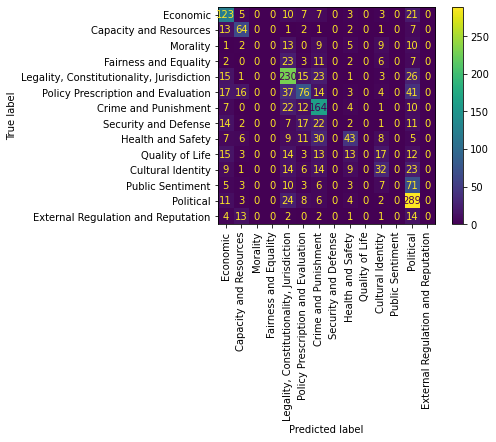

In [21]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

_,test_results = test_model(model, tokenizer, test_x_batches, test_y_batches, articles, only_spans, device, loss_fn)
preds = [t[0] for t in test_results]
reals = [t[1] for t in test_results]

codes = labels
with open("../../mfc_v4.0/codes.json", "r") as f:
    codebook = json.load(f)
    codes = [codebook[str(label)] for label in labels if labels.index(label) <= max(max(reals),max(preds))]

disp = ConfusionMatrixDisplay(
        confusion_matrix(reals, preds),
        display_labels=codes
    )
disp.plot()
plt.xticks(rotation=90)
plt.show()


In [22]:
from sklearn.metrics import f1_score as f1

test_results = test_model(model, tokenizer, test_x_batches, test_y_batches, articles, only_spans, device)
preds = [t[0] for t in test_results]
reals = [t[1] for t in test_results]

label_set = set(reals+preds)

codes = labels
with open("../../mfc_v4.0/codes.json", "r") as f:
    codebook = json.load(f)
    codes = [codebook[str(label)] for label in labels if labels.index(label) <= max(max(reals),max(preds))]
    
print("Micro F1 Score:", f1(reals, preds, average='micro'))
print("Macro F1 Score:", f1(reals, preds, average='macro'))
print("Weighted F1 Score:", f1(reals, preds, average='weighted'))
f1_dict = dict([(codes[label], f1([int(e==label) for e in reals],[int(e==label) for e in preds])) for label in label_set])
print("All F1 Scores:")
for key in f1_dict:
    print(key, f1_dict[key])

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Model Accuracy: 0.5241935483870968
Micro F1 Score: 0.5241935483870968
Macro F1 Score: 0.3045038346244196
Weighted F1 Score: 0.4576095964778754
All F1 Scores:
Economic 0.5517241379310346
Capacity and Resources 0.6041666666666666
Morality 0.0
Fairness and Equality 0.0
Legality, Constitutionality, Jurisdiction 0.646900269541779
Policy Prescription and Evaluation 0.41711229946524064
Crime and Punishment 0.6217228464419475
Security and Defense 0.0
Health and Safety 0.34693877551020413
Quality of Life 0.0
Cultural Identity 0.41071428571428575
Public Sentiment 0.0
Political 0.6637744034707159
External Regulation and Reputation 0.0


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training Loss at step 0 : 2.707951307296753
Training Loss at step 10 : 2.7039952278137207
Training Loss at step 20 : 2.705681562423706
Training Loss at step 30 : 2.704738140106201
Training Loss at step 40 : 2.6989595890045166
Training Loss at step 50 : 2.7026028633117676
Training Loss at step 60 : 2.6997768878936768
Training Loss at step 70 : 2.6999635696411133
Training Loss at step 80 : 2.699197292327881
Training Loss at step 90 : 2.694065809249878
Training Loss at step 100 : 2.694868803024292
Training Loss at step 110 : 2.6983368396759033
Training Loss at step 120 : 2.6993231773376465
Training Loss at step 130 : 2.6835668087005615
Training Loss at step 140 : 2.6911749839782715
Training Loss at step 150 : 2.698179244995117
Training Loss at step 160 : 2.6874301433563232
Training Loss at step 170 : 2.6825971603393555
Training Loss at step 180 : 2.6784355640411377
Training Loss at step 190 : 2.6969645023345947
Training Loss at step 200 : 2.674309015274048
Training Loss at step 210 : 2.67

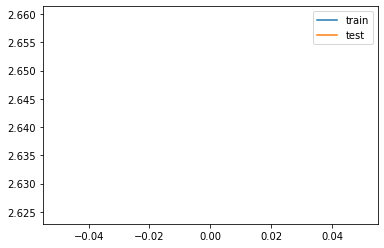

Training Loss at step 1010 : 2.605475902557373
Training Loss at step 1020 : 2.6560611724853516
Training Loss at step 1030 : 2.642855644226074
Training Loss at step 1040 : 2.5474677085876465
Training Loss at step 1050 : 2.5961248874664307
Training Loss at step 1060 : 2.6771373748779297
Training Loss at step 1070 : 2.6477625370025635
Training Loss at step 1080 : 2.6437838077545166
Training Loss at step 1090 : 2.5880656242370605
Training Loss at step 1100 : 2.6392483711242676
Training Loss at step 1110 : 2.6185688972473145
Training Loss at step 1120 : 2.64727783203125
Training Loss at step 1130 : 2.6554763317108154
Training Loss at step 1140 : 2.6205508708953857
Training Loss at step 1150 : 2.636061906814575
Training Loss at step 1160 : 2.566927671432495
Training Loss at step 1170 : 2.6084675788879395
Training Loss at step 1180 : 2.6412036418914795
Training Loss at step 1190 : 2.6708548069000244
Training Loss at step 1200 : 2.6852519512176514
Training Loss at step 1210 : 2.695951461791992

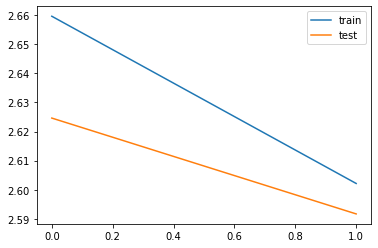

Training Loss at step 2010 : 2.5882151126861572
Training Loss at step 2020 : 2.584951639175415
Training Loss at step 2030 : 2.6490747928619385
Training Loss at step 2040 : 2.6134707927703857
Training Loss at step 2050 : 2.573349714279175
Training Loss at step 2060 : 2.5518412590026855
Training Loss at step 2070 : 2.5231034755706787
Training Loss at step 2080 : 2.5613648891448975
Training Loss at step 2090 : 2.4377312660217285
Training Loss at step 2100 : 2.5725953578948975
Training Loss at step 2110 : 2.5856940746307373
Training Loss at step 2120 : 2.568416118621826
Training Loss at step 2130 : 2.581392765045166
Training Loss at step 2140 : 2.6349775791168213
Training Loss at step 2150 : 2.5802111625671387
Training Loss at step 2160 : 2.6650454998016357
Training Loss at step 2170 : 2.623933792114258
Training Loss at step 2180 : 2.5704548358917236
Training Loss at step 2190 : 2.48129940032959
Training Loss at step 2200 : 2.631866455078125
Training Loss at step 2210 : 2.5314908027648926


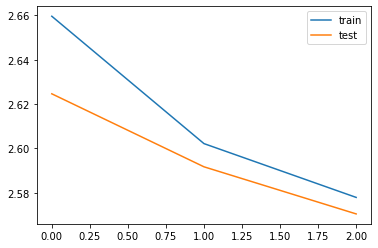

Training Loss at step 3010 : 2.4766693115234375
Training Loss at step 3020 : 2.4456512928009033
Training Loss at step 3030 : 2.5730929374694824
Training Loss at step 3040 : 2.639871120452881
Training Loss at step 3050 : 2.554758071899414
Training Loss at step 3060 : 2.6192374229431152
Training Loss at step 3070 : 2.593808174133301
Training Loss at step 3080 : 2.6063919067382812
Training Loss at step 3090 : 2.519428253173828
Training Loss at step 3100 : 2.5019543170928955
Training Loss at step 3110 : 2.5265097618103027
Training Loss at step 3120 : 2.639589309692383
Training Loss at step 3130 : 2.4416213035583496
Training Loss at step 3140 : 2.6019911766052246
Training Loss at step 3150 : 2.51287841796875
Training Loss at step 3160 : 2.4841792583465576
Training Loss at step 3170 : 2.4848530292510986
Training Loss at step 3180 : 2.52535343170166
Training Loss at step 3190 : 2.5233314037323
Training Loss at step 3200 : 2.5428972244262695
Training Loss at step 3210 : 2.4923622608184814
Trai

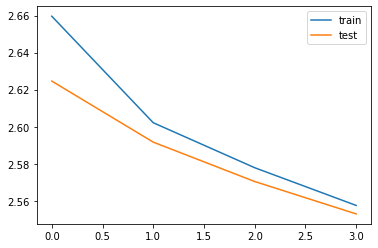

Training Loss at step 4010 : 2.5623581409454346
Training Loss at step 4020 : 2.562676429748535
Training Loss at step 4030 : 2.4998555183410645
Training Loss at step 4040 : 2.4574618339538574
Training Loss at step 4050 : 2.6015946865081787
Training Loss at step 4060 : 2.590244770050049
Training Loss at step 4070 : 2.5184073448181152
Training Loss at step 4080 : 2.4962308406829834
Training Loss at step 4090 : 2.5780887603759766
Training Loss at step 4100 : 2.6360278129577637
Training Loss at step 4110 : 2.6199305057525635
Training Loss at step 4120 : 2.36338210105896
Training Loss at step 4130 : 2.4338231086730957
Training Loss at step 4140 : 2.561272621154785
Training Loss at step 4150 : 2.5124635696411133
Training Loss at step 4160 : 2.5316007137298584
Training Loss at step 4170 : 2.5669686794281006
Training Loss at step 4180 : 2.5188393592834473
Training Loss at step 4190 : 2.510171413421631
Training Loss at step 4200 : 2.5134201049804688
Training Loss at step 4210 : 2.606210470199585

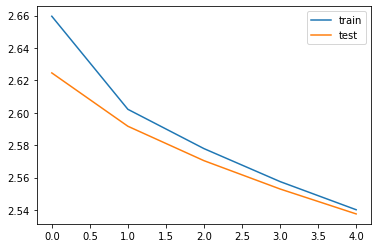

Training Loss at step 5010 : 2.5367956161499023
Training Loss at step 5020 : 2.462019205093384
Training Loss at step 5030 : 2.45528507232666
Training Loss at step 5040 : 2.5185513496398926
Training Loss at step 5050 : 2.591542959213257
Training Loss at step 5060 : 2.636021614074707
Training Loss at step 5070 : 2.5515365600585938
Training Loss at step 5080 : 2.573873996734619
Training Loss at step 5090 : 2.6371517181396484
Training Loss at step 5100 : 2.604355812072754
Training Loss at step 5110 : 2.510333776473999
Training Loss at step 5120 : 2.5272538661956787
Training Loss at step 5130 : 2.5084002017974854
Training Loss at step 5140 : 2.441685438156128
Training Loss at step 5150 : 2.491766929626465
Training Loss at step 5160 : 2.568924903869629
Training Loss at step 5170 : 2.603691339492798
Training Loss at step 5180 : 2.5605626106262207
Training Loss at step 5190 : 2.4917893409729004
Training Loss at step 5200 : 2.5669522285461426
Training Loss at step 5210 : 2.5572452545166016
Trai

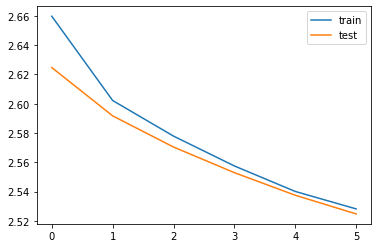

Training Loss at step 6010 : 2.5957019329071045
Training Loss at step 6020 : 2.605531692504883
Training Loss at step 6030 : 2.558248281478882
Training Loss at step 6040 : 2.4844324588775635
Training Loss at step 6050 : 2.4833157062530518
Training Loss at step 6060 : 2.505496025085449
Training Loss at step 6070 : 2.4949803352355957
Training Loss at step 6080 : 2.521155834197998
Training Loss at step 6090 : 2.6493310928344727
Training Loss at step 6100 : 2.5745973587036133
Training Loss at step 6110 : 2.4057116508483887
Training Loss at step 6120 : 2.644253730773926
Training Loss at step 6130 : 2.5503122806549072
Training Loss at step 6140 : 2.367100477218628
Training Loss at step 6150 : 2.4250457286834717
Training Loss at step 6160 : 2.370426893234253
Training Loss at step 6170 : 2.609450340270996
Training Loss at step 6180 : 2.4535934925079346
Training Loss at step 6190 : 2.5021908283233643
Training Loss at step 6200 : 2.5302963256835938
Training Loss at step 6210 : 2.5738754272460938


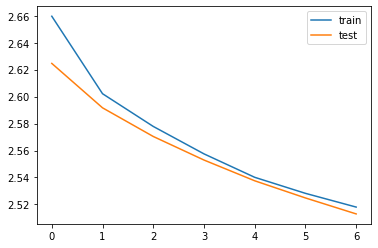

Training Loss at step 7010 : 2.544848918914795
Training Loss at step 7020 : 2.6404995918273926
Training Loss at step 7030 : 2.4912455081939697
Training Loss at step 7040 : 2.5551953315734863
Training Loss at step 7050 : 2.4686005115509033
Training Loss at step 7060 : 2.512042999267578
Training Loss at step 7070 : 2.4825124740600586
Training Loss at step 7080 : 2.6022160053253174
Training Loss at step 7090 : 2.522688388824463
Training Loss at step 7100 : 2.5607550144195557
Training Loss at step 7110 : 2.365880250930786
Training Loss at step 7120 : 2.4540979862213135
Training Loss at step 7130 : 2.5278897285461426
Training Loss at step 7140 : 2.466585874557495
Training Loss at step 7150 : 2.3960695266723633
Training Loss at step 7160 : 2.486370086669922
Training Loss at step 7170 : 2.5931613445281982
Training Loss at step 7180 : 2.5023281574249268
Training Loss at step 7190 : 2.5587382316589355
Training Loss at step 7200 : 2.491729497909546
Training Loss at step 7210 : 2.550455093383789


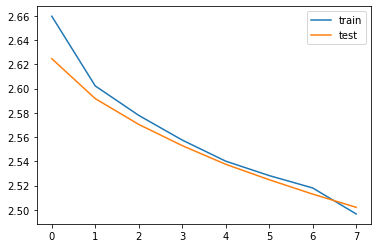

Training Loss at step 8010 : 2.514814853668213
Training Loss at step 8020 : 2.4680655002593994
Training Loss at step 8030 : 2.4433987140655518
Training Loss at step 8040 : 2.5296287536621094
Training Loss at step 8050 : 2.472916603088379
Training Loss at step 8060 : 2.56829571723938
Training Loss at step 8070 : 2.4368999004364014
Training Loss at step 8080 : 2.4723336696624756
Training Loss at step 8090 : 2.5120890140533447
Training Loss at step 8100 : 2.5170390605926514
Training Loss at step 8110 : 2.347947120666504
Training Loss at step 8120 : 2.5015475749969482
Training Loss at step 8130 : 2.5296316146850586
Training Loss at step 8140 : 2.4878575801849365
Training Loss at step 8150 : 2.476717948913574
Training Loss at step 8160 : 2.661862850189209
Training Loss at step 8170 : 2.5561444759368896
Training Loss at step 8180 : 2.284085988998413
Training Loss at step 8190 : 2.5201683044433594
Training Loss at step 8200 : 2.540017604827881
Training Loss at step 8210 : 2.4771018028259277
T

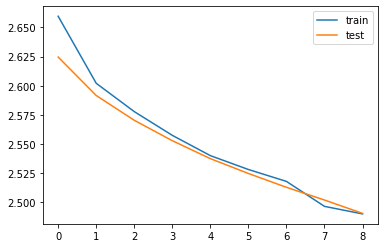

Training Loss at step 9010 : 2.5359480381011963
Training Loss at step 9020 : 2.5337846279144287
Training Loss at step 9030 : 2.5166752338409424
Training Loss at step 9040 : 2.4586596488952637
Training Loss at step 9050 : 2.5609612464904785
Training Loss at step 9060 : 2.526796340942383
Training Loss at step 9070 : 2.577977418899536
Training Loss at step 9080 : 2.53090763092041
Training Loss at step 9090 : 2.575331687927246
Training Loss at step 9100 : 2.5664453506469727
Training Loss at step 9110 : 2.4086902141571045
Training Loss at step 9120 : 2.4765589237213135
Training Loss at step 9130 : 2.412112236022949
Training Loss at step 9140 : 2.5194029808044434
Training Loss at step 9150 : 2.4628005027770996
Training Loss at step 9160 : 2.505910634994507
Training Loss at step 9170 : 2.450096607208252
Training Loss at step 9180 : 2.5039126873016357
Training Loss at step 9190 : 2.5153262615203857
Training Loss at step 9200 : 2.434922933578491
Training Loss at step 9210 : 2.4155733585357666
T

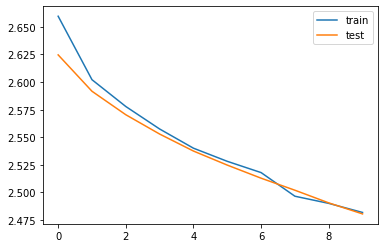

Training Loss at step 10010 : 2.478614330291748
Training Loss at step 10020 : 2.6319408416748047
Training Loss at step 10030 : 2.545191764831543
Training Loss at step 10040 : 2.4422521591186523
Training Loss at step 10050 : 2.403212785720825
Training Loss at step 10060 : 2.3273932933807373
Training Loss at step 10070 : 2.492551326751709
Training Loss at step 10080 : 2.4625895023345947
Training Loss at step 10090 : 2.38504695892334
Training Loss at step 10100 : 2.312260866165161
Training Loss at step 10110 : 2.445936918258667
Training Loss at step 10120 : 2.3700790405273438
Training Loss at step 10130 : 2.5418434143066406
Training Loss at step 10140 : 2.354140520095825
Training Loss at step 10150 : 2.448636293411255
Training Loss at step 10160 : 2.3992714881896973
Training Loss at step 10170 : 2.5706496238708496
Training Loss at step 10180 : 2.4448251724243164
Training Loss at step 10190 : 2.5490667819976807
Training Loss at step 10200 : 2.360846996307373
Training Loss at step 10210 : 2

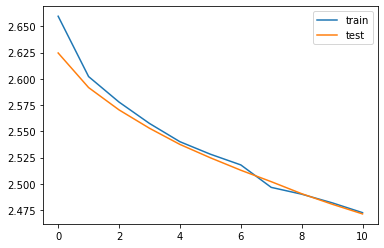

Training Loss at step 11010 : 2.60014271736145
Training Loss at step 11020 : 2.3901636600494385
Training Loss at step 11030 : 2.486079454421997
Training Loss at step 11040 : 2.362393617630005
Training Loss at step 11050 : 2.6450552940368652
Training Loss at step 11060 : 2.3856899738311768
Training Loss at step 11070 : 2.4126834869384766
Training Loss at step 11080 : 2.4901328086853027
Training Loss at step 11090 : 2.552987813949585
Training Loss at step 11100 : 2.4562394618988037
Training Loss at step 11110 : 2.4245707988739014
Training Loss at step 11120 : 2.5966949462890625
Training Loss at step 11130 : 2.466618776321411
Training Loss at step 11140 : 2.491119384765625
Training Loss at step 11150 : 2.5093929767608643
Training Loss at step 11160 : 2.5240519046783447
Training Loss at step 11170 : 2.4850032329559326
Training Loss at step 11180 : 2.463301658630371
Training Loss at step 11190 : 2.5032880306243896
Training Loss at step 11200 : 2.626857042312622
Training Loss at step 11210 :

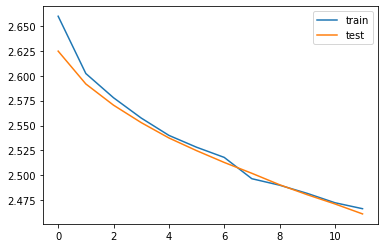

Training Loss at step 12010 : 2.639796257019043
Training Loss at step 12020 : 2.5285162925720215
Training Loss at step 12030 : 2.470223903656006
Training Loss at step 12040 : 2.448244571685791
Training Loss at step 12050 : 2.400606632232666
Training Loss at step 12060 : 2.358700752258301
Training Loss at step 12070 : 2.3100690841674805
Training Loss at step 12080 : 2.4025626182556152
Training Loss at step 12090 : 2.5031628608703613
Training Loss at step 12100 : 2.5596790313720703
Training Loss at step 12110 : 2.3593595027923584
Training Loss at step 12120 : 2.4405627250671387
Training Loss at step 12130 : 2.4114480018615723
Training Loss at step 12140 : 2.4305484294891357
Training Loss at step 12150 : 2.4373512268066406
Training Loss at step 12160 : 2.2566866874694824
Training Loss at step 12170 : 2.5020346641540527
Training Loss at step 12180 : 2.518915891647339
Training Loss at step 12190 : 2.473933458328247
Training Loss at step 12200 : 2.434128999710083
Training Loss at step 12210 

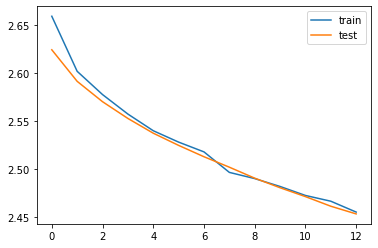

Training Loss at step 13010 : 2.378617763519287
Training Loss at step 13020 : 2.5579769611358643
Training Loss at step 13030 : 2.657360076904297
Training Loss at step 13040 : 2.487259864807129
Training Loss at step 13050 : 2.5233728885650635
Training Loss at step 13060 : 2.45247483253479
Training Loss at step 13070 : 2.5603506565093994
Training Loss at step 13080 : 2.403442859649658
Training Loss at step 13090 : 2.437096357345581
Training Loss at step 13100 : 2.3506081104278564
Training Loss at step 13110 : 2.46045184135437
Training Loss at step 13120 : 2.5547451972961426
Training Loss at step 13130 : 2.49395751953125
Training Loss at step 13140 : 2.318946361541748
Training Loss at step 13150 : 2.536628246307373
Training Loss at step 13160 : 2.3084557056427
Training Loss at step 13170 : 2.4137532711029053
Training Loss at step 13180 : 2.4038398265838623
Training Loss at step 13190 : 2.5605733394622803
Training Loss at step 13200 : 2.4711225032806396
Training Loss at step 13210 : 2.4792

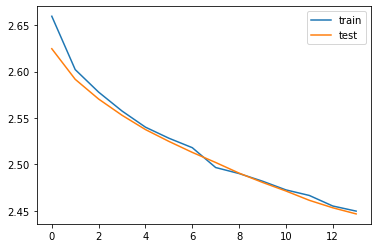

Training Loss at step 14010 : 2.348022937774658
Training Loss at step 14020 : 2.5175905227661133
Training Loss at step 14030 : 2.345531463623047
Training Loss at step 14040 : 2.5321061611175537
Training Loss at step 14050 : 2.463047981262207
Training Loss at step 14060 : 2.32612943649292
Training Loss at step 14070 : 2.3456602096557617
Training Loss at step 14080 : 2.387300729751587
Training Loss at step 14090 : 2.539774179458618
Training Loss at step 14100 : 2.483628034591675
Training Loss at step 14110 : 2.5222320556640625
Training Loss at step 14120 : 2.458705425262451
Training Loss at step 14130 : 2.5386040210723877
Training Loss at step 14140 : 2.1203951835632324
Training Loss at step 14150 : 2.504551887512207
Training Loss at step 14160 : 2.480271577835083
Training Loss at step 14170 : 2.4199705123901367
Training Loss at step 14180 : 2.495884895324707
Training Loss at step 14190 : 2.3812732696533203
Training Loss at step 14200 : 2.2926254272460938
Training Loss at step 14210 : 2.

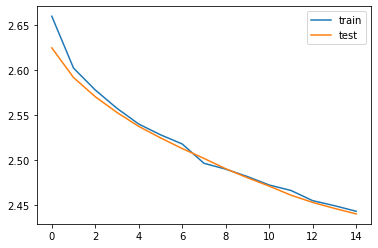

Training Loss at step 15010 : 2.3663489818573
Training Loss at step 15020 : 2.456571340560913
Training Loss at step 15030 : 2.5776262283325195
Training Loss at step 15040 : 2.4490370750427246
Training Loss at step 15050 : 2.4579250812530518
Training Loss at step 15060 : 2.337155342102051
Training Loss at step 15070 : 2.3590598106384277
Training Loss at step 15080 : 2.4826772212982178
Training Loss at step 15090 : 2.469132900238037
Training Loss at step 15100 : 2.5052738189697266
Training Loss at step 15110 : 2.382669687271118
Training Loss at step 15120 : 2.537445306777954
Training Loss at step 15130 : 2.5185580253601074
Training Loss at step 15140 : 2.3503730297088623
Training Loss at step 15150 : 2.484025716781616
Training Loss at step 15160 : 2.3216447830200195
Training Loss at step 15170 : 2.3018991947174072
Training Loss at step 15180 : 2.4777910709381104
Training Loss at step 15190 : 2.4815328121185303
Training Loss at step 15200 : 2.3432300090789795
Training Loss at step 15210 :

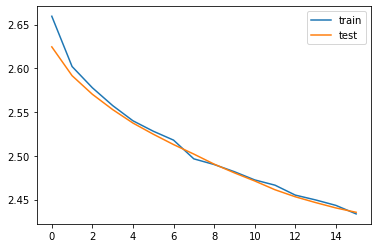

Training Loss at step 16010 : 2.556673526763916
Training Loss at step 16020 : 2.3743646144866943
Training Loss at step 16030 : 2.428205728530884
Training Loss at step 16040 : 2.5856480598449707
Training Loss at step 16050 : 2.4146487712860107
Training Loss at step 16060 : 2.3200860023498535
Training Loss at step 16070 : 2.419280767440796
Training Loss at step 16080 : 2.5580124855041504
Training Loss at step 16090 : 2.3886313438415527
Training Loss at step 16100 : 2.4021708965301514
Training Loss at step 16110 : 2.38167142868042
Training Loss at step 16120 : 2.497554302215576
Training Loss at step 16130 : 2.4348702430725098
Training Loss at step 16140 : 2.6186373233795166
Training Loss at step 16150 : 2.5718703269958496
Training Loss at step 16160 : 2.4526147842407227
Training Loss at step 16170 : 2.5055129528045654
Training Loss at step 16180 : 2.5272481441497803
Training Loss at step 16190 : 2.408609628677368
Training Loss at step 16200 : 2.535858631134033
Training Loss at step 16210 

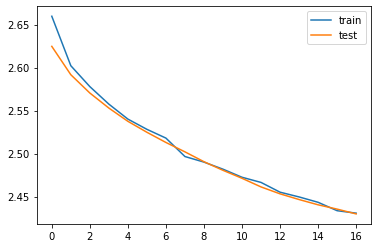

Training Loss at step 17010 : 2.490504503250122
Training Loss at step 17020 : 2.5363008975982666
Training Loss at step 17030 : 2.4240636825561523
Training Loss at step 17040 : 2.4544897079467773
Training Loss at step 17050 : 2.415160655975342
Training Loss at step 17060 : 2.549145460128784
Training Loss at step 17070 : 2.2590906620025635
Training Loss at step 17080 : 2.403496742248535
Training Loss at step 17090 : 2.3698019981384277
Training Loss at step 17100 : 2.406198263168335
Training Loss at step 17110 : 2.4730751514434814
Training Loss at step 17120 : 2.45296573638916
Training Loss at step 17130 : 2.366152286529541
Training Loss at step 17140 : 2.1936583518981934
Training Loss at step 17150 : 2.446608066558838
Training Loss at step 17160 : 2.475078582763672
Training Loss at step 17170 : 2.341703176498413
Training Loss at step 17180 : 2.3784940242767334
Training Loss at step 17190 : 2.3393807411193848
Training Loss at step 17200 : 2.552849292755127
Training Loss at step 17210 : 2.

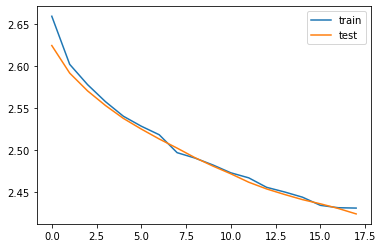

Training Loss at step 18010 : 2.495246171951294
Training Loss at step 18020 : 2.413264274597168
Training Loss at step 18030 : 2.4796338081359863
Training Loss at step 18040 : 2.433117151260376
Training Loss at step 18050 : 2.527667760848999
Training Loss at step 18060 : 2.540416955947876
Training Loss at step 18070 : 2.352750539779663
Training Loss at step 18080 : 2.3231301307678223
Training Loss at step 18090 : 2.3795299530029297
Training Loss at step 18100 : 2.387937307357788
Training Loss at step 18110 : 2.6277546882629395
Training Loss at step 18120 : 2.4969122409820557
Training Loss at step 18130 : 2.1955599784851074
Training Loss at step 18140 : 2.32079815864563
Training Loss at step 18150 : 2.487398147583008
Training Loss at step 18160 : 2.22507643699646
Training Loss at step 18170 : 2.4441874027252197
Training Loss at step 18180 : 2.2935991287231445
Training Loss at step 18190 : 2.384084939956665
Training Loss at step 18200 : 2.4102964401245117
Training Loss at step 18210 : 2.5

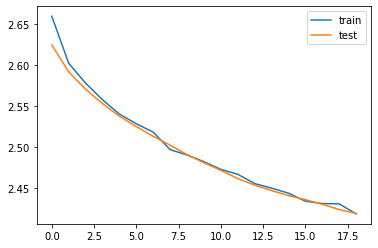

Training Loss at step 19010 : 2.450869083404541
Training Loss at step 19020 : 2.4876275062561035
Training Loss at step 19030 : 2.3010194301605225
Training Loss at step 19040 : 2.39845871925354
Training Loss at step 19050 : 2.308291435241699
Training Loss at step 19060 : 2.42586350440979
Training Loss at step 19070 : 2.2304511070251465
Training Loss at step 19080 : 2.3016581535339355
Training Loss at step 19090 : 2.4619483947753906
Training Loss at step 19100 : 2.5694737434387207
Training Loss at step 19110 : 2.525751829147339
Training Loss at step 19120 : 2.3656997680664062
Training Loss at step 19130 : 2.3159115314483643
Training Loss at step 19140 : 2.399705171585083
Training Loss at step 19150 : 2.4977798461914062
Training Loss at step 19160 : 2.5474894046783447
Training Loss at step 19170 : 2.3448405265808105
Training Loss at step 19180 : 2.4300479888916016
Training Loss at step 19190 : 2.413869619369507
Training Loss at step 19200 : 2.370614767074585
Training Loss at step 19210 : 

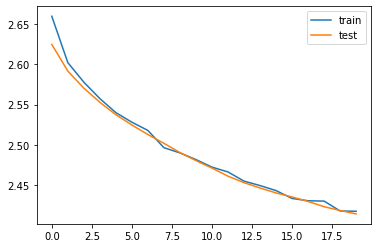

Training Loss at step 20010 : 2.389632225036621
Training Loss at step 20020 : 2.4200429916381836
Training Loss at step 20030 : 2.460463523864746
Training Loss at step 20040 : 2.4643325805664062
Training Loss at step 20050 : 2.450363874435425
Training Loss at step 20060 : 2.479111433029175
Training Loss at step 20070 : 2.2753639221191406
Training Loss at step 20080 : 2.3729629516601562
Training Loss at step 20090 : 2.2863643169403076
Training Loss at step 20100 : 2.4943883419036865
Training Loss at step 20110 : 2.3709168434143066
Training Loss at step 20120 : 2.4438185691833496
Training Loss at step 20130 : 2.324566125869751
Training Loss at step 20140 : 2.318995714187622
Training Loss at step 20150 : 2.3951704502105713
Training Loss at step 20160 : 2.3619022369384766
Training Loss at step 20170 : 2.4608893394470215
Training Loss at step 20180 : 2.5247230529785156
Training Loss at step 20190 : 2.3668971061706543
Training Loss at step 20200 : 2.438225269317627
Training Loss at step 20210

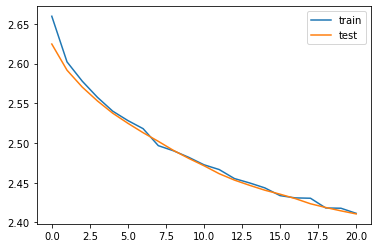

Training Loss at step 21010 : 2.50472092628479
Training Loss at step 21020 : 2.3771743774414062
Training Loss at step 21030 : 2.430939197540283
Training Loss at step 21040 : 2.5811619758605957
Training Loss at step 21050 : 2.455540180206299
Training Loss at step 21060 : 2.439302921295166
Training Loss at step 21070 : 2.403029680252075
Training Loss at step 21080 : 2.5647706985473633
Training Loss at step 21090 : 2.2590112686157227
Training Loss at step 21100 : 2.4738945960998535
Training Loss at step 21110 : 2.3899970054626465
Training Loss at step 21120 : 2.5464212894439697
Training Loss at step 21130 : 2.4178836345672607
Training Loss at step 21140 : 2.3446176052093506
Training Loss at step 21150 : 2.4099879264831543
Training Loss at step 21160 : 2.5833497047424316
Training Loss at step 21170 : 2.3863577842712402
Training Loss at step 21180 : 2.388122320175171
Training Loss at step 21190 : 2.4964427947998047
Training Loss at step 21200 : 2.420527935028076
Training Loss at step 21210 

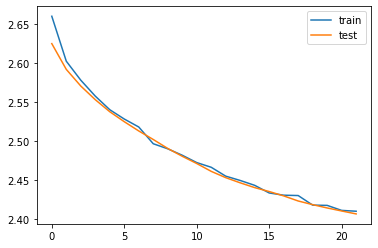

Training Loss at step 22010 : 2.369171142578125
Training Loss at step 22020 : 2.556041955947876
Training Loss at step 22030 : 2.430042028427124
Training Loss at step 22040 : 2.3866639137268066
Training Loss at step 22050 : 2.5153043270111084
Training Loss at step 22060 : 2.455153226852417
Training Loss at step 22070 : 2.2643120288848877
Training Loss at step 22080 : 2.50900936126709
Training Loss at step 22090 : 2.5458030700683594
Training Loss at step 22100 : 2.3469319343566895
Training Loss at step 22110 : 2.437849998474121
Training Loss at step 22120 : 2.282724380493164
Training Loss at step 22130 : 2.35746693611145
Training Loss at step 22140 : 2.49068021774292
Training Loss at step 22150 : 2.4998371601104736
Training Loss at step 22160 : 2.4544920921325684
Training Loss at step 22170 : 2.1287484169006348
Training Loss at step 22180 : 2.331780195236206
Training Loss at step 22190 : 2.304460287094116
Training Loss at step 22200 : 2.3947629928588867
Training Loss at step 22210 : 2.37

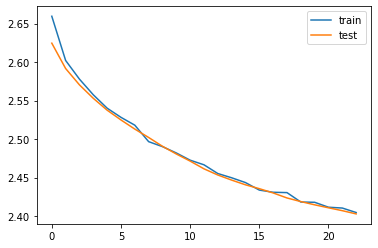

Training Loss at step 23010 : 2.4916160106658936
Training Loss at step 23020 : 2.557504653930664
Training Loss at step 23030 : 2.334106922149658
Training Loss at step 23040 : 2.3079280853271484
Training Loss at step 23050 : 2.317110300064087
Training Loss at step 23060 : 2.3889482021331787
Training Loss at step 23070 : 2.4270710945129395
Training Loss at step 23080 : 2.372072219848633
Training Loss at step 23090 : 2.31594181060791
Training Loss at step 23100 : 2.505525827407837
Training Loss at step 23110 : 2.329559326171875
Training Loss at step 23120 : 2.385697603225708
Training Loss at step 23130 : 2.446956157684326
Training Loss at step 23140 : 2.364213705062866
Training Loss at step 23150 : 2.4676034450531006
Training Loss at step 23160 : 2.3707053661346436
Training Loss at step 23170 : 2.2827436923980713
Training Loss at step 23180 : 2.373380422592163
Training Loss at step 23190 : 2.317190408706665
Training Loss at step 23200 : 2.340937376022339
Training Loss at step 23210 : 2.44

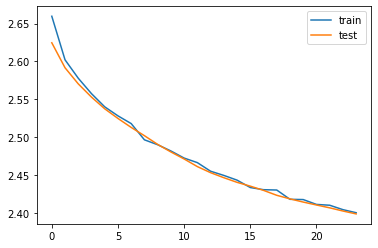

Training Loss at step 24010 : 2.618805408477783
Training Loss at step 24020 : 2.4894797801971436
Training Loss at step 24030 : 2.2804489135742188
Training Loss at step 24040 : 2.315735340118408
Training Loss at step 24050 : 2.466547966003418
Training Loss at step 24060 : 2.3462066650390625
Training Loss at step 24070 : 2.404125213623047
Training Loss at step 24080 : 2.4819555282592773
Training Loss at step 24090 : 2.4858651161193848
Training Loss at step 24100 : 2.383002281188965
Training Loss at step 24110 : 2.3299503326416016
Training Loss at step 24120 : 2.3335976600646973
Training Loss at step 24130 : 2.4405293464660645
Training Loss at step 24140 : 2.38045072555542
Training Loss at step 24150 : 2.345407247543335
Training Loss at step 24160 : 2.608907699584961
Training Loss at step 24170 : 2.415867805480957
Training Loss at step 24180 : 2.315656900405884
Training Loss at step 24190 : 2.3945515155792236
Training Loss at step 24200 : 2.3503577709198
Training Loss at step 24210 : 2.25

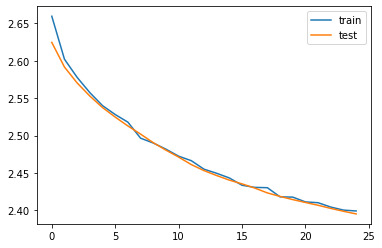

Training Loss at step 25010 : 2.3678665161132812
Training Loss at step 25020 : 2.387831449508667
Training Loss at step 25030 : 2.3356516361236572
Training Loss at step 25040 : 2.4830129146575928
Training Loss at step 25050 : 2.4242308139801025
Training Loss at step 25060 : 2.5418620109558105
Training Loss at step 25070 : 2.509791135787964
Training Loss at step 25080 : 2.3161404132843018
Training Loss at step 25090 : 2.4172587394714355
Training Loss at step 25100 : 2.432910919189453
Training Loss at step 25110 : 2.4960899353027344
Training Loss at step 25120 : 2.3697657585144043
Training Loss at step 25130 : 2.4476547241210938
Training Loss at step 25140 : 2.581651449203491
Training Loss at step 25150 : 2.4556884765625
Training Loss at step 25160 : 2.361222505569458
Training Loss at step 25170 : 2.437509059906006
Training Loss at step 25180 : 2.3339626789093018
Training Loss at step 25190 : 2.400404930114746
Training Loss at step 25200 : 2.465639591217041
Training Loss at step 25210 : 2

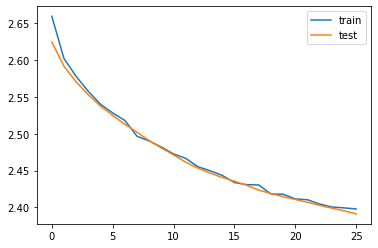

Training Loss at step 26010 : 2.329474449157715
Training Loss at step 26020 : 2.4123475551605225
Training Loss at step 26030 : 2.2764651775360107
Training Loss at step 26040 : 2.516879081726074
Training Loss at step 26050 : 2.481128692626953
Training Loss at step 26060 : 2.3489160537719727
Training Loss at step 26070 : 2.444746732711792
Training Loss at step 26080 : 2.4323525428771973
Training Loss at step 26090 : 2.2506179809570312
Training Loss at step 26100 : 2.337444305419922
Training Loss at step 26110 : 2.521821975708008
Training Loss at step 26120 : 2.3783860206604004
Training Loss at step 26130 : 2.396466016769409
Training Loss at step 26140 : 2.4835946559906006
Training Loss at step 26150 : 2.413911819458008
Training Loss at step 26160 : 2.4000651836395264
Training Loss at step 26170 : 2.5702452659606934
Training Loss at step 26180 : 2.372666597366333
Training Loss at step 26190 : 2.3468151092529297
Training Loss at step 26200 : 2.4171786308288574
Training Loss at step 26210 :

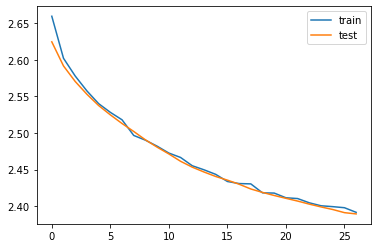

Training Loss at step 27010 : 2.2952191829681396
Training Loss at step 27020 : 2.5498809814453125
Training Loss at step 27030 : 2.314032554626465
Training Loss at step 27040 : 2.3410143852233887
Training Loss at step 27050 : 2.390735387802124
Training Loss at step 27060 : 2.177737236022949
Training Loss at step 27070 : 2.4229137897491455
Training Loss at step 27080 : 2.3284995555877686
Training Loss at step 27090 : 2.569794178009033
Training Loss at step 27100 : 2.310215950012207
Training Loss at step 27110 : 2.207557201385498
Training Loss at step 27120 : 2.3274176120758057
Training Loss at step 27130 : 2.3982765674591064
Training Loss at step 27140 : 2.2566277980804443
Training Loss at step 27150 : 2.4497430324554443
Training Loss at step 27160 : 2.4933900833129883
Training Loss at step 27170 : 2.274649143218994
Training Loss at step 27180 : 2.444105625152588
Training Loss at step 27190 : 2.3989014625549316
Training Loss at step 27200 : 2.471463441848755
Training Loss at step 27210 :

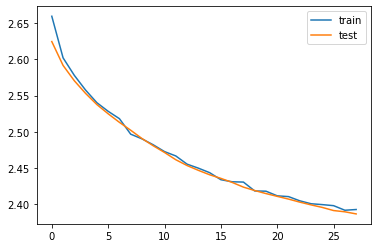

Training Loss at step 28010 : 2.2751870155334473
Training Loss at step 28020 : 2.4331698417663574
Training Loss at step 28030 : 2.2699873447418213
Training Loss at step 28040 : 2.3796610832214355
Training Loss at step 28050 : 2.4066731929779053
Training Loss at step 28060 : 2.36826753616333
Training Loss at step 28070 : 2.4768545627593994
Training Loss at step 28080 : 2.4811031818389893
Training Loss at step 28090 : 2.4723856449127197
Training Loss at step 28100 : 2.4075236320495605
Training Loss at step 28110 : 2.392343282699585
Training Loss at step 28120 : 2.3904037475585938
Training Loss at step 28130 : 2.422788143157959
Training Loss at step 28140 : 2.500912666320801
Training Loss at step 28150 : 2.479321002960205
Training Loss at step 28160 : 2.242666006088257
Training Loss at step 28170 : 2.398613214492798
Training Loss at step 28180 : 2.353717803955078
Training Loss at step 28190 : 2.461876153945923
Training Loss at step 28200 : 2.495143175125122
Training Loss at step 28210 : 2

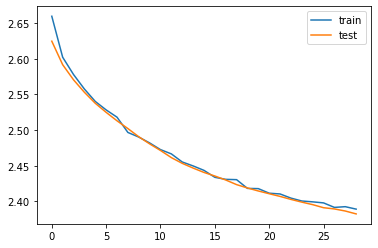

Training Loss at step 29010 : 2.5095598697662354
Training Loss at step 29020 : 2.4556937217712402
Training Loss at step 29030 : 2.496082067489624
Training Loss at step 29040 : 2.4505772590637207
Training Loss at step 29050 : 2.4582457542419434
Training Loss at step 29060 : 2.318967819213867
Training Loss at step 29070 : 2.4381513595581055
Training Loss at step 29080 : 2.3573904037475586
Training Loss at step 29090 : 2.431025266647339
Training Loss at step 29100 : 2.3407363891601562
Training Loss at step 29110 : 2.3030576705932617
Training Loss at step 29120 : 2.3735015392303467
Training Loss at step 29130 : 2.4939327239990234
Training Loss at step 29140 : 2.4379165172576904
Training Loss at step 29150 : 2.3921761512756348
Training Loss at step 29160 : 2.5062179565429688
Training Loss at step 29170 : 2.291022539138794
Training Loss at step 29180 : 2.4057834148406982
Training Loss at step 29190 : 2.409148931503296
Training Loss at step 29200 : 2.42560076713562
Training Loss at step 29210

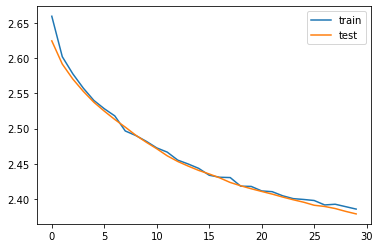

Training Loss at step 30010 : 2.29598069190979
Training Loss at step 30020 : 2.524052143096924
Training Loss at step 30030 : 2.322300672531128
Training Loss at step 30040 : 2.4177298545837402
Training Loss at step 30050 : 2.4670560359954834
Training Loss at step 30060 : 2.307856559753418
Training Loss at step 30070 : 2.3871047496795654
Training Loss at step 30080 : 2.4467058181762695
Training Loss at step 30090 : 2.313129186630249
Training Loss at step 30100 : 2.4480831623077393
Training Loss at step 30110 : 2.5496439933776855
Training Loss at step 30120 : 2.3659238815307617
Training Loss at step 30130 : 2.3711471557617188
Training Loss at step 30140 : 2.3335061073303223
Training Loss at step 30150 : 2.5021157264709473
Training Loss at step 30160 : 2.2079076766967773
Training Loss at step 30170 : 2.348315477371216
Training Loss at step 30180 : 2.3784804344177246
Training Loss at step 30190 : 2.508169412612915
Training Loss at step 30200 : 2.4218902587890625
Training Loss at step 30210 

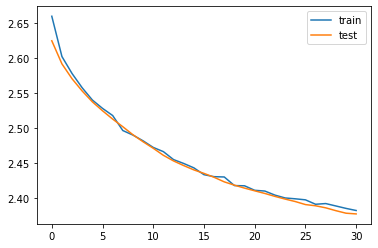

Training Loss at step 31010 : 2.274021863937378
Training Loss at step 31020 : 2.4372432231903076
Training Loss at step 31030 : 2.3576440811157227
Training Loss at step 31040 : 2.4266397953033447
Training Loss at step 31050 : 2.3546953201293945
Training Loss at step 31060 : 2.2390124797821045
Training Loss at step 31070 : 2.354832649230957
Training Loss at step 31080 : 2.3589189052581787
Training Loss at step 31090 : 2.3576323986053467
Training Loss at step 31100 : 2.3745555877685547
Training Loss at step 31110 : 2.283463716506958
Training Loss at step 31120 : 2.5131540298461914
Training Loss at step 31130 : 2.3113787174224854
Training Loss at step 31140 : 2.4626646041870117
Training Loss at step 31150 : 2.3772408962249756
Training Loss at step 31160 : 2.4532246589660645
Training Loss at step 31170 : 2.3265795707702637
Training Loss at step 31180 : 2.3574395179748535
Training Loss at step 31190 : 2.2198147773742676
Training Loss at step 31200 : 2.3897109031677246
Training Loss at step 3

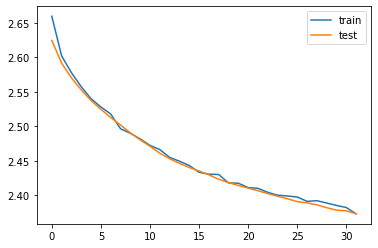

Training Loss at step 32010 : 2.354890823364258
Training Loss at step 32020 : 2.3480920791625977
Training Loss at step 32030 : 2.3185043334960938
Training Loss at step 32040 : 2.459625244140625
Training Loss at step 32050 : 2.296194553375244
Training Loss at step 32060 : 2.4659507274627686
Training Loss at step 32070 : 2.407320022583008
Training Loss at step 32080 : 2.4012467861175537
Training Loss at step 32090 : 2.382676839828491
Training Loss at step 32100 : 2.4938302040100098
Training Loss at step 32110 : 2.329224109649658
Training Loss at step 32120 : 2.386124849319458
Training Loss at step 32130 : 2.4396185874938965
Training Loss at step 32140 : 2.496814489364624
Training Loss at step 32150 : 2.4670870304107666
Training Loss at step 32160 : 2.2912375926971436
Training Loss at step 32170 : 2.451643943786621
Training Loss at step 32180 : 2.3319995403289795
Training Loss at step 32190 : 2.4774250984191895
Training Loss at step 32200 : 2.4346957206726074
Training Loss at step 32210 :

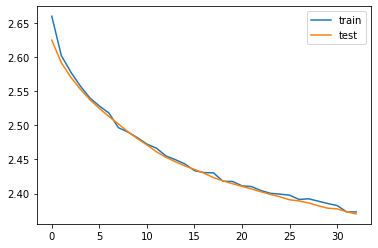

Training Loss at step 33010 : 2.4255523681640625
Training Loss at step 33020 : 2.3909406661987305
Training Loss at step 33030 : 2.320047616958618
Training Loss at step 33040 : 2.5273566246032715
Training Loss at step 33050 : 2.3579187393188477
Training Loss at step 33060 : 2.4340178966522217
Training Loss at step 33070 : 2.408607244491577
Training Loss at step 33080 : 2.4853875637054443
Training Loss at step 33090 : 2.353221893310547
Training Loss at step 33100 : 2.4441609382629395
Training Loss at step 33110 : 2.5380139350891113
Training Loss at step 33120 : 2.2547109127044678
Training Loss at step 33130 : 2.1822969913482666
Training Loss at step 33140 : 2.309757947921753
Training Loss at step 33150 : 2.38179612159729
Training Loss at step 33160 : 2.328972578048706
Training Loss at step 33170 : 2.427891969680786
Training Loss at step 33180 : 2.453737735748291
Training Loss at step 33190 : 2.0675675868988037
Training Loss at step 33200 : 2.4599556922912598
Training Loss at step 33210 :

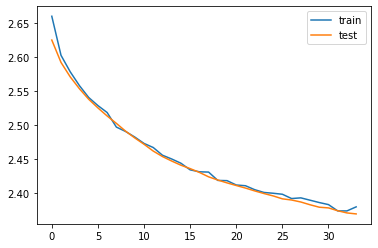

Training Loss at step 34010 : 2.444638252258301
Training Loss at step 34020 : 2.383636951446533
Training Loss at step 34030 : 2.438626766204834
Training Loss at step 34040 : 2.3043675422668457
Training Loss at step 34050 : 2.4293134212493896
Training Loss at step 34060 : 2.379805564880371
Training Loss at step 34070 : 2.4712142944335938
Training Loss at step 34080 : 2.415675401687622
Training Loss at step 34090 : 2.4220001697540283
Training Loss at step 34100 : 2.4655165672302246
Training Loss at step 34110 : 2.2728054523468018
Training Loss at step 34120 : 2.369723320007324
Training Loss at step 34130 : 2.298025131225586
Training Loss at step 34140 : 2.1419076919555664
Training Loss at step 34150 : 2.345376491546631
Training Loss at step 34160 : 2.2617316246032715
Training Loss at step 34170 : 2.233612537384033
Training Loss at step 34180 : 2.279714584350586
Training Loss at step 34190 : 2.305729389190674
Training Loss at step 34200 : 2.374868631362915
Training Loss at step 34210 : 2.

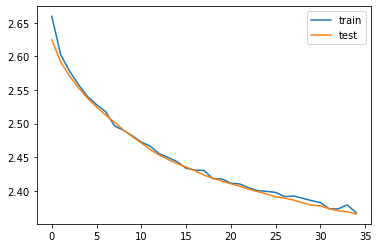

Training Loss at step 1010 : 2.322598934173584
Training Loss at step 1020 : 2.248657703399658
Training Loss at step 1030 : 2.3333122730255127
Training Loss at step 1040 : 2.250059127807617
Training Loss at step 1050 : 2.3193905353546143
Training Loss at step 1060 : 2.5263566970825195
Training Loss at step 1070 : 2.4033844470977783
Training Loss at step 1080 : 2.4278035163879395
Training Loss at step 1090 : 2.3065128326416016
Training Loss at step 1100 : 2.4329445362091064
Training Loss at step 1110 : 2.195086717605591
Training Loss at step 1120 : 2.4198062419891357
Training Loss at step 1130 : 2.4421579837799072
Training Loss at step 1140 : 2.5259547233581543
Training Loss at step 1150 : 2.2388057708740234
Training Loss at step 1160 : 2.3300538063049316
Training Loss at step 1170 : 2.375760793685913
Training Loss at step 1180 : 2.4345295429229736
Training Loss at step 1190 : 2.3059301376342773
Training Loss at step 1200 : 2.569127082824707
Training Loss at step 1210 : 2.558857917785644

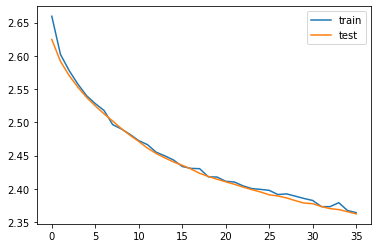

Training Loss at step 2010 : 2.255871057510376
Training Loss at step 2020 : 2.400723695755005
Training Loss at step 2030 : 2.3702633380889893
Training Loss at step 2040 : 2.3104469776153564
Training Loss at step 2050 : 2.378230094909668
Training Loss at step 2060 : 2.28733229637146
Training Loss at step 2070 : 2.240969657897949
Training Loss at step 2080 : 2.2878499031066895
Training Loss at step 2090 : 2.1603095531463623
Training Loss at step 2100 : 2.3768577575683594
Training Loss at step 2110 : 2.433178663253784
Training Loss at step 2120 : 2.3258302211761475
Training Loss at step 2130 : 2.3436455726623535
Training Loss at step 2140 : 2.386181592941284
Training Loss at step 2150 : 2.444312334060669
Training Loss at step 2160 : 2.468417167663574
Training Loss at step 2170 : 2.3382771015167236
Training Loss at step 2180 : 2.2928972244262695
Training Loss at step 2190 : 2.298133134841919
Training Loss at step 2200 : 2.3647572994232178
Training Loss at step 2210 : 2.2697620391845703
Tra

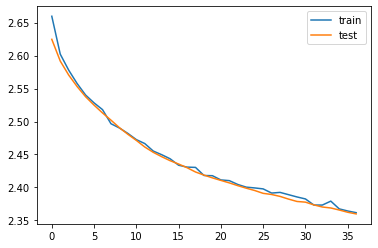

Training Loss at step 3010 : 2.2109897136688232
Training Loss at step 3020 : 2.2954485416412354
Training Loss at step 3030 : 2.424811363220215
Training Loss at step 3040 : 2.4597582817077637
Training Loss at step 3050 : 2.419548511505127
Training Loss at step 3060 : 2.491269111633301
Training Loss at step 3070 : 2.322984218597412
Training Loss at step 3080 : 2.435746908187866
Training Loss at step 3090 : 2.337738037109375
Training Loss at step 3100 : 2.3339145183563232
Training Loss at step 3110 : 2.352954387664795
Training Loss at step 3120 : 2.5425782203674316
Training Loss at step 3130 : 2.245924949645996
Training Loss at step 3140 : 2.497213125228882
Training Loss at step 3150 : 2.315119981765747
Training Loss at step 3160 : 2.323726177215576
Training Loss at step 3170 : 2.3341116905212402
Training Loss at step 3180 : 2.346388578414917
Training Loss at step 3190 : 2.35852313041687
Training Loss at step 3200 : 2.2865653038024902
Training Loss at step 3210 : 2.3771708011627197
Traini

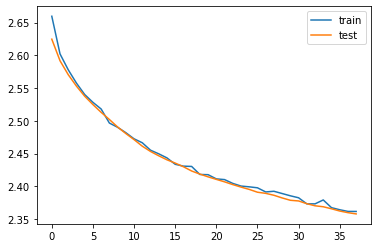

Training Loss at step 4010 : 2.180333375930786
Training Loss at step 4020 : 2.370546340942383
Training Loss at step 4030 : 2.449138879776001
Training Loss at step 4040 : 2.36405611038208
Training Loss at step 4050 : 2.4300639629364014
Training Loss at step 4060 : 2.4971723556518555
Training Loss at step 4070 : 2.3139657974243164
Training Loss at step 4080 : 2.1918036937713623
Training Loss at step 4090 : 2.389646053314209
Training Loss at step 4100 : 2.3866353034973145
Training Loss at step 4110 : 2.41903018951416
Training Loss at step 4120 : 2.234135389328003
Training Loss at step 4130 : 2.2396695613861084
Training Loss at step 4140 : 2.396179676055908
Training Loss at step 4150 : 2.3037571907043457
Training Loss at step 4160 : 2.4084393978118896
Training Loss at step 4170 : 2.2990806102752686
Training Loss at step 4180 : 2.35090970993042
Training Loss at step 4190 : 2.371227502822876
Training Loss at step 4200 : 2.340672016143799
Training Loss at step 4210 : 2.4322829246520996
Traini

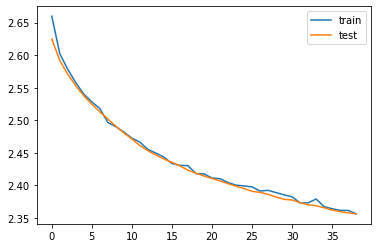

Training Loss at step 5010 : 2.3555808067321777
Training Loss at step 5020 : 2.3007795810699463
Training Loss at step 5030 : 2.2716989517211914
Training Loss at step 5040 : 2.398703098297119
Training Loss at step 5050 : 2.442678451538086
Training Loss at step 5060 : 2.4778218269348145
Training Loss at step 5070 : 2.4209742546081543
Training Loss at step 5080 : 2.348507881164551
Training Loss at step 5090 : 2.458123207092285
Training Loss at step 5100 : 2.3674912452697754
Training Loss at step 5110 : 2.3676602840423584
Training Loss at step 5120 : 2.3676536083221436
Training Loss at step 5130 : 2.2549984455108643
Training Loss at step 5140 : 2.327693462371826
Training Loss at step 5150 : 2.3362770080566406
Training Loss at step 5160 : 2.374314785003662
Training Loss at step 5170 : 2.406494140625
Training Loss at step 5180 : 2.429004430770874
Training Loss at step 5190 : 2.3016769886016846
Training Loss at step 5200 : 2.447101354598999
Training Loss at step 5210 : 2.293238401412964
Train

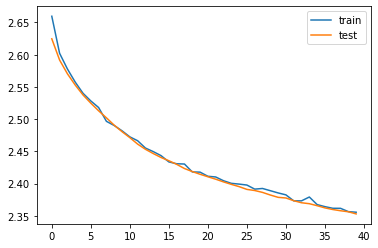

Training Loss at step 6010 : 2.352489948272705
Training Loss at step 6020 : 2.432356119155884
Training Loss at step 6030 : 2.3128485679626465
Training Loss at step 6040 : 2.3700132369995117
Training Loss at step 6050 : 2.3244569301605225
Training Loss at step 6060 : 2.421877145767212
Training Loss at step 6070 : 2.2942006587982178
Training Loss at step 6080 : 2.3277132511138916
Training Loss at step 6090 : 2.5120601654052734
Training Loss at step 6100 : 2.484626293182373
Training Loss at step 6110 : 2.2277400493621826
Training Loss at step 6120 : 2.3810644149780273
Training Loss at step 6130 : 2.414857864379883
Training Loss at step 6140 : 2.2102036476135254
Training Loss at step 6150 : 2.256659746170044
Training Loss at step 6160 : 2.2205233573913574
Training Loss at step 6170 : 2.47084641456604
Training Loss at step 6180 : 2.258213520050049
Training Loss at step 6190 : 2.389251947402954
Training Loss at step 6200 : 2.453617811203003
Training Loss at step 6210 : 2.399240255355835
Trai

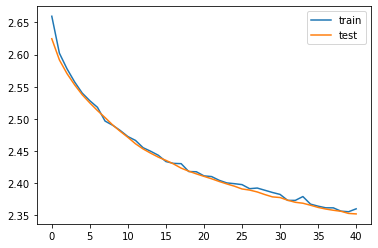

Training Loss at step 7010 : 2.4403958320617676
Training Loss at step 7020 : 2.618368148803711
Training Loss at step 7030 : 2.297837734222412
Training Loss at step 7040 : 2.448550224304199
Training Loss at step 7050 : 2.304241895675659
Training Loss at step 7060 : 2.2566771507263184
Training Loss at step 7070 : 2.378844976425171
Training Loss at step 7080 : 2.551755905151367
Training Loss at step 7090 : 2.4337007999420166
Training Loss at step 7100 : 2.447110414505005
Training Loss at step 7110 : 2.1792380809783936
Training Loss at step 7120 : 2.4082953929901123
Training Loss at step 7130 : 2.3641438484191895
Training Loss at step 7140 : 2.3877315521240234
Training Loss at step 7150 : 2.3057727813720703
Training Loss at step 7160 : 2.318967819213867
Training Loss at step 7170 : 2.4006340503692627
Training Loss at step 7180 : 2.369990587234497
Training Loss at step 7190 : 2.403998374938965
Training Loss at step 7200 : 2.4160995483398438
Training Loss at step 7210 : 2.4689507484436035
Tr

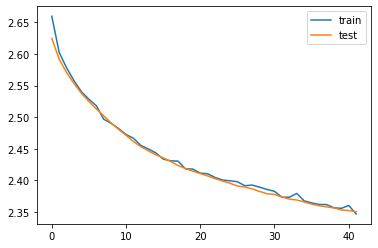

Training Loss at step 8010 : 2.40533447265625
Training Loss at step 8020 : 2.298400402069092
Training Loss at step 8030 : 2.26930832862854
Training Loss at step 8040 : 2.31648588180542
Training Loss at step 8050 : 2.4008066654205322
Training Loss at step 8060 : 2.3352131843566895
Training Loss at step 8070 : 2.348083257675171
Training Loss at step 8080 : 2.359541893005371
Training Loss at step 8090 : 2.320659637451172
Training Loss at step 8100 : 2.224323272705078
Training Loss at step 8110 : 2.212277412414551
Training Loss at step 8120 : 2.315147638320923
Training Loss at step 8130 : 2.3819031715393066
Training Loss at step 8140 : 2.425092935562134
Training Loss at step 8150 : 2.3832743167877197
Training Loss at step 8160 : 2.4816181659698486
Training Loss at step 8170 : 2.4271488189697266
Training Loss at step 8180 : 2.210200548171997
Training Loss at step 8190 : 2.436099052429199
Training Loss at step 8200 : 2.4600305557250977
Training Loss at step 8210 : 2.324659585952759
Training 

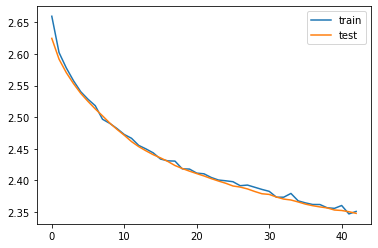

Training Loss at step 9010 : 2.3945655822753906
Training Loss at step 9020 : 2.336854934692383
Training Loss at step 9030 : 2.344651937484741
Training Loss at step 9040 : 2.350728988647461
Training Loss at step 9050 : 2.461069107055664
Training Loss at step 9060 : 2.363565444946289
Training Loss at step 9070 : 2.5653610229492188
Training Loss at step 9080 : 2.4147720336914062
Training Loss at step 9090 : 2.5398523807525635
Training Loss at step 9100 : 2.401236057281494
Training Loss at step 9110 : 2.346735954284668
Training Loss at step 9120 : 2.27421236038208
Training Loss at step 9130 : 2.2654287815093994
Training Loss at step 9140 : 2.3530824184417725
Training Loss at step 9150 : 2.359288215637207
Training Loss at step 9160 : 2.389267683029175
Training Loss at step 9170 : 2.2590742111206055
Training Loss at step 9180 : 2.3025355339050293
Training Loss at step 9190 : 2.4103446006774902
Training Loss at step 9200 : 2.265655755996704
Training Loss at step 9210 : 2.2324368953704834
Trai

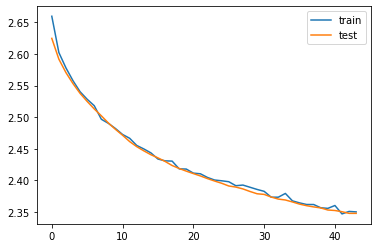

Training Loss at step 10010 : 2.402028799057007
Training Loss at step 10020 : 2.490262269973755
Training Loss at step 10030 : 2.502164840698242
Training Loss at step 10040 : 2.3003811836242676
Training Loss at step 10050 : 2.2760908603668213
Training Loss at step 10060 : 2.070082426071167
Training Loss at step 10070 : 2.3896493911743164
Training Loss at step 10080 : 2.2649149894714355
Training Loss at step 10090 : 2.256521224975586
Training Loss at step 10100 : 2.233985185623169
Training Loss at step 10110 : 2.356689691543579
Training Loss at step 10120 : 2.2298803329467773
Training Loss at step 10130 : 2.448232650756836
Training Loss at step 10140 : 2.2042829990386963
Training Loss at step 10150 : 2.2559075355529785
Training Loss at step 10160 : 2.3541860580444336
Training Loss at step 10170 : 2.373004674911499
Training Loss at step 10180 : 2.377511978149414
Training Loss at step 10190 : 2.4386098384857178
Training Loss at step 10200 : 2.161398410797119
Training Loss at step 10210 : 2

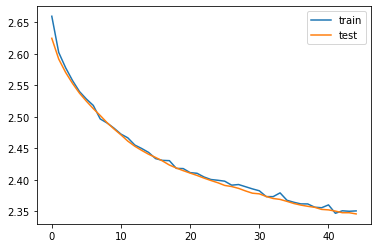

Training Loss at step 11010 : 2.4593636989593506
Training Loss at step 11020 : 2.2819302082061768
Training Loss at step 11030 : 2.3409438133239746
Training Loss at step 11040 : 2.1981611251831055
Training Loss at step 11050 : 2.4866251945495605
Training Loss at step 11060 : 2.178401470184326
Training Loss at step 11070 : 2.3365302085876465
Training Loss at step 11080 : 2.366032123565674
Training Loss at step 11090 : 2.3941996097564697
Training Loss at step 11100 : 2.383007049560547
Training Loss at step 11110 : 2.309932231903076
Training Loss at step 11120 : 2.517343282699585
Training Loss at step 11130 : 2.2760651111602783
Training Loss at step 11140 : 2.4354841709136963
Training Loss at step 11150 : 2.4335031509399414
Training Loss at step 11160 : 2.310559034347534
Training Loss at step 11170 : 2.3203043937683105
Training Loss at step 11180 : 2.3739428520202637
Training Loss at step 11190 : 2.359468936920166
Training Loss at step 11200 : 2.593668222427368
Training Loss at step 11210 

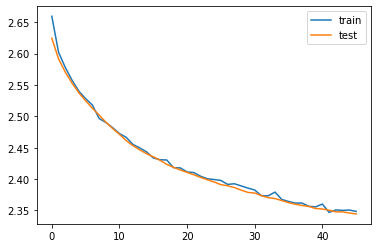

Training Loss at step 12010 : 2.5139565467834473
Training Loss at step 12020 : 2.4779984951019287
Training Loss at step 12030 : 2.331498622894287
Training Loss at step 12040 : 2.3520002365112305
Training Loss at step 12050 : 2.3446738719940186
Training Loss at step 12060 : 2.3019986152648926
Training Loss at step 12070 : 2.119429588317871
Training Loss at step 12080 : 2.399207830429077
Training Loss at step 12090 : 2.4022979736328125
Training Loss at step 12100 : 2.3891451358795166
Training Loss at step 12110 : 2.2367892265319824
Training Loss at step 12120 : 2.3401355743408203
Training Loss at step 12130 : 2.2859280109405518
Training Loss at step 12140 : 2.355928897857666
Training Loss at step 12150 : 2.258821487426758
Training Loss at step 12160 : 2.172835111618042
Training Loss at step 12170 : 2.406559705734253
Training Loss at step 12180 : 2.367664337158203
Training Loss at step 12190 : 2.3829030990600586
Training Loss at step 12200 : 2.2976794242858887
Training Loss at step 12210 

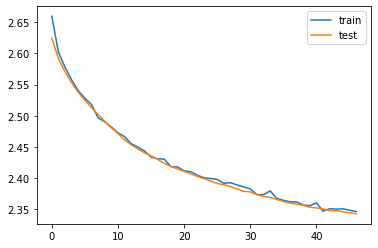

Training Loss at step 13010 : 2.2683961391448975
Training Loss at step 13020 : 2.4119327068328857
Training Loss at step 13030 : 2.4719574451446533
Training Loss at step 13040 : 2.412818670272827
Training Loss at step 13050 : 2.419550895690918
Training Loss at step 13060 : 2.348167896270752
Training Loss at step 13070 : 2.4492671489715576
Training Loss at step 13080 : 2.299513339996338
Training Loss at step 13090 : 2.321047306060791
Training Loss at step 13100 : 2.2551167011260986
Training Loss at step 13110 : 2.2288475036621094
Training Loss at step 13120 : 2.4609947204589844
Training Loss at step 13130 : 2.3825020790100098
Training Loss at step 13140 : 2.16971492767334
Training Loss at step 13150 : 2.4243531227111816
Training Loss at step 13160 : 2.1803832054138184
Training Loss at step 13170 : 2.205983877182007
Training Loss at step 13180 : 2.3550376892089844
Training Loss at step 13190 : 2.3076939582824707
Training Loss at step 13200 : 2.3414809703826904
Training Loss at step 13210 

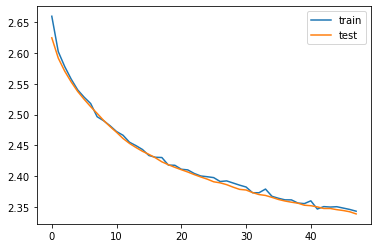

Training Loss at step 14010 : 2.317554473876953
Training Loss at step 14020 : 2.458448886871338
Training Loss at step 14030 : 2.238342523574829
Training Loss at step 14040 : 2.468353748321533
Training Loss at step 14050 : 2.320758104324341
Training Loss at step 14060 : 2.24399471282959
Training Loss at step 14070 : 2.223895311355591
Training Loss at step 14080 : 2.309976577758789
Training Loss at step 14090 : 2.4555702209472656
Training Loss at step 14100 : 2.382575511932373
Training Loss at step 14110 : 2.374083995819092
Training Loss at step 14120 : 2.4148435592651367
Training Loss at step 14130 : 2.401529312133789
Training Loss at step 14140 : 2.072868585586548
Training Loss at step 14150 : 2.4117190837860107
Training Loss at step 14160 : 2.391131639480591
Training Loss at step 14170 : 2.277070999145508
Training Loss at step 14180 : 2.411651372909546
Training Loss at step 14190 : 2.2388617992401123
Training Loss at step 14200 : 2.2234108448028564
Training Loss at step 14210 : 2.3193

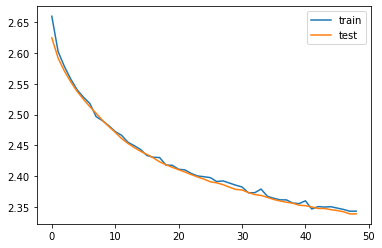

Training Loss at step 15010 : 2.345715045928955
Training Loss at step 15020 : 2.424541473388672
Training Loss at step 15030 : 2.507068157196045
Training Loss at step 15040 : 2.2871756553649902
Training Loss at step 15050 : 2.399681806564331
Training Loss at step 15060 : 2.2049474716186523
Training Loss at step 15070 : 2.225074291229248
Training Loss at step 15080 : 2.42120099067688
Training Loss at step 15090 : 2.3572728633880615
Training Loss at step 15100 : 2.309657573699951
Training Loss at step 15110 : 2.254101037979126
Training Loss at step 15120 : 2.460538148880005
Training Loss at step 15130 : 2.423762321472168
Training Loss at step 15140 : 2.2493557929992676
Training Loss at step 15150 : 2.3190951347351074
Training Loss at step 15160 : 2.235866069793701
Training Loss at step 15170 : 2.2129311561584473
Training Loss at step 15180 : 2.419848918914795
Training Loss at step 15190 : 2.3470394611358643
Training Loss at step 15200 : 2.268158435821533
Training Loss at step 15210 : 2.43

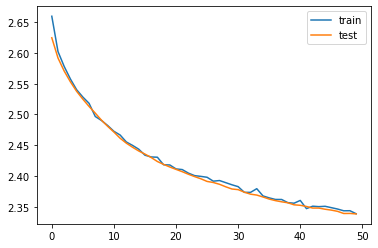

Training Loss at step 16010 : 2.4212687015533447
Training Loss at step 16020 : 2.2703702449798584
Training Loss at step 16030 : 2.3454065322875977
Training Loss at step 16040 : 2.449396848678589
Training Loss at step 16050 : 2.3250858783721924
Training Loss at step 16060 : 2.252045154571533
Training Loss at step 16070 : 2.3485867977142334
Training Loss at step 16080 : 2.5112597942352295
Training Loss at step 16090 : 2.307966470718384
Training Loss at step 16100 : 2.374652147293091
Training Loss at step 16110 : 2.252929210662842
Training Loss at step 16120 : 2.3601431846618652
Training Loss at step 16130 : 2.368779420852661
Training Loss at step 16140 : 2.547283887863159
Training Loss at step 16150 : 2.5144057273864746
Training Loss at step 16160 : 2.313077688217163
Training Loss at step 16170 : 2.37683367729187
Training Loss at step 16180 : 2.436901569366455
Training Loss at step 16190 : 2.3072240352630615
Training Loss at step 16200 : 2.4239091873168945
Training Loss at step 16210 : 2

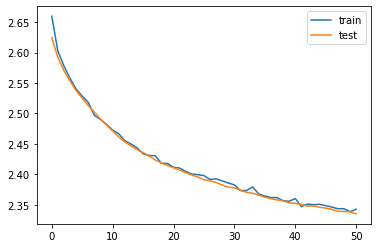

Training Loss at step 17010 : 2.3821773529052734
Training Loss at step 17020 : 2.486924886703491
Training Loss at step 17030 : 2.281430244445801
Training Loss at step 17040 : 2.3872203826904297
Training Loss at step 17050 : 2.325866460800171
Training Loss at step 17060 : 2.472484588623047
Training Loss at step 17070 : 2.14518141746521
Training Loss at step 17080 : 2.3943607807159424
Training Loss at step 17090 : 2.3112425804138184
Training Loss at step 17100 : 2.3653368949890137
Training Loss at step 17110 : 2.39520263671875
Training Loss at step 17120 : 2.234907388687134
Training Loss at step 17130 : 2.25347900390625
Training Loss at step 17140 : 2.074294090270996
Training Loss at step 17150 : 2.4052059650421143
Training Loss at step 17160 : 2.4171674251556396
Training Loss at step 17170 : 2.262300968170166
Training Loss at step 17180 : 2.3432042598724365
Training Loss at step 17190 : 2.2998087406158447
Training Loss at step 17200 : 2.4348886013031006
Training Loss at step 17210 : 2.3

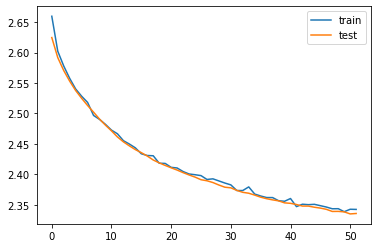

Training Loss at step 18010 : 2.363860845565796
Training Loss at step 18020 : 2.3250248432159424
Training Loss at step 18030 : 2.3884713649749756
Training Loss at step 18040 : 2.3390614986419678
Training Loss at step 18050 : 2.460751533508301
Training Loss at step 18060 : 2.4575438499450684
Training Loss at step 18070 : 2.252631664276123
Training Loss at step 18080 : 2.203834056854248
Training Loss at step 18090 : 2.256730556488037
Training Loss at step 18100 : 2.2141308784484863
Training Loss at step 18110 : 2.5147900581359863
Training Loss at step 18120 : 2.3773193359375
Training Loss at step 18130 : 2.1567225456237793
Training Loss at step 18140 : 2.2790989875793457
Training Loss at step 18150 : 2.32572603225708
Training Loss at step 18160 : 2.1473188400268555
Training Loss at step 18170 : 2.355170249938965
Training Loss at step 18180 : 2.215545415878296
Training Loss at step 18190 : 2.3409037590026855
Training Loss at step 18200 : 2.366271495819092
Training Loss at step 18210 : 2.4

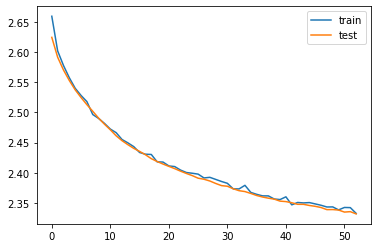

Training Loss at step 19010 : 2.432985782623291
Training Loss at step 19020 : 2.403768539428711
Training Loss at step 19030 : 2.27506160736084
Training Loss at step 19040 : 2.377134323120117
Training Loss at step 19050 : 2.240753650665283
Training Loss at step 19060 : 2.3578124046325684
Training Loss at step 19070 : 2.1326167583465576
Training Loss at step 19080 : 2.2359564304351807
Training Loss at step 19090 : 2.2739760875701904
Training Loss at step 19100 : 2.4602274894714355
Training Loss at step 19110 : 2.4378085136413574
Training Loss at step 19120 : 2.2765355110168457
Training Loss at step 19130 : 2.215869903564453
Training Loss at step 19140 : 2.2432563304901123
Training Loss at step 19150 : 2.446547269821167
Training Loss at step 19160 : 2.470715284347534
Training Loss at step 19170 : 2.242915153503418
Training Loss at step 19180 : 2.3802568912506104
Training Loss at step 19190 : 2.318502426147461
Training Loss at step 19200 : 2.306110382080078
Training Loss at step 19210 : 2.

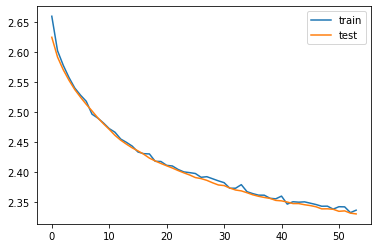

Training Loss at step 20010 : 2.285501003265381
Training Loss at step 20020 : 2.355544090270996
Training Loss at step 20030 : 2.426435947418213
Training Loss at step 20040 : 2.375607967376709
Training Loss at step 20050 : 2.2763500213623047
Training Loss at step 20060 : 2.4285888671875
Training Loss at step 20070 : 2.2383615970611572
Training Loss at step 20080 : 2.3060050010681152
Training Loss at step 20090 : 2.13729190826416
Training Loss at step 20100 : 2.4099173545837402
Training Loss at step 20110 : 2.340221643447876
Training Loss at step 20120 : 2.3873651027679443
Training Loss at step 20130 : 2.26768159866333
Training Loss at step 20140 : 2.229646682739258
Training Loss at step 20150 : 2.3290605545043945
Training Loss at step 20160 : 2.2465710639953613
Training Loss at step 20170 : 2.386914014816284
Training Loss at step 20180 : 2.4500837326049805
Training Loss at step 20190 : 2.2154407501220703
Training Loss at step 20200 : 2.3259856700897217
Training Loss at step 20210 : 2.35

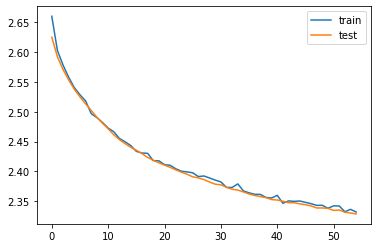

Training Loss at step 21010 : 2.41284441947937
Training Loss at step 21020 : 2.3359832763671875
Training Loss at step 21030 : 2.383978843688965
Training Loss at step 21040 : 2.5463104248046875
Training Loss at step 21050 : 2.337054967880249
Training Loss at step 21060 : 2.3254904747009277
Training Loss at step 21070 : 2.3743908405303955
Training Loss at step 21080 : 2.469399929046631
Training Loss at step 21090 : 2.153926134109497
Training Loss at step 21100 : 2.4311559200286865
Training Loss at step 21110 : 2.348581314086914
Training Loss at step 21120 : 2.5127687454223633
Training Loss at step 21130 : 2.366025924682617
Training Loss at step 21140 : 2.311798095703125
Training Loss at step 21150 : 2.3161211013793945
Training Loss at step 21160 : 2.541560411453247
Training Loss at step 21170 : 2.3226256370544434
Training Loss at step 21180 : 2.267021894454956
Training Loss at step 21190 : 2.3421790599823
Training Loss at step 21200 : 2.2991416454315186
Training Loss at step 21210 : 2.44

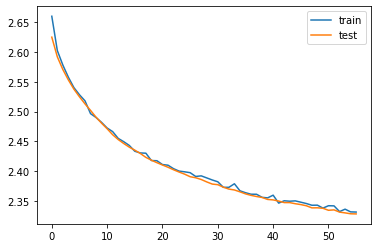

Training Loss at step 22010 : 2.3527185916900635
Training Loss at step 22020 : 2.4981117248535156
Training Loss at step 22030 : 2.2909069061279297
Training Loss at step 22040 : 2.3096771240234375
Training Loss at step 22050 : 2.4626710414886475
Training Loss at step 22060 : 2.419109344482422
Training Loss at step 22070 : 2.2337188720703125
Training Loss at step 22080 : 2.4609968662261963
Training Loss at step 22090 : 2.4624078273773193
Training Loss at step 22100 : 2.3153467178344727
Training Loss at step 22110 : 2.367063045501709
Training Loss at step 22120 : 2.241921901702881
Training Loss at step 22130 : 2.2873106002807617
Training Loss at step 22140 : 2.422220230102539
Training Loss at step 22150 : 2.3375465869903564
Training Loss at step 22160 : 2.3870174884796143
Training Loss at step 22170 : 2.0704116821289062
Training Loss at step 22180 : 2.278977155685425
Training Loss at step 22190 : 2.228642702102661
Training Loss at step 22200 : 2.2969281673431396
Training Loss at step 2221

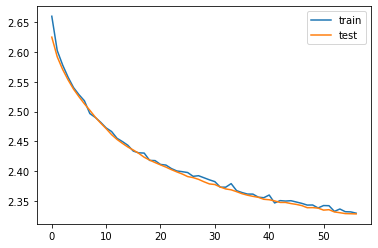

Training Loss at step 23010 : 2.3900721073150635
Training Loss at step 23020 : 2.442232370376587
Training Loss at step 23030 : 2.256340980529785
Training Loss at step 23040 : 2.219514846801758
Training Loss at step 23050 : 2.2981081008911133
Training Loss at step 23060 : 2.316920042037964
Training Loss at step 23070 : 2.382471799850464
Training Loss at step 23080 : 2.3458118438720703
Training Loss at step 23090 : 2.2551393508911133
Training Loss at step 23100 : 2.343994379043579
Training Loss at step 23110 : 2.290351390838623
Training Loss at step 23120 : 2.2544095516204834
Training Loss at step 23130 : 2.374129056930542
Training Loss at step 23140 : 2.2820215225219727
Training Loss at step 23150 : 2.4269871711730957
Training Loss at step 23160 : 2.263568162918091
Training Loss at step 23170 : 2.1537973880767822
Training Loss at step 23180 : 2.3378822803497314
Training Loss at step 23190 : 2.3064169883728027
Training Loss at step 23200 : 2.3203513622283936
Training Loss at step 23210 :

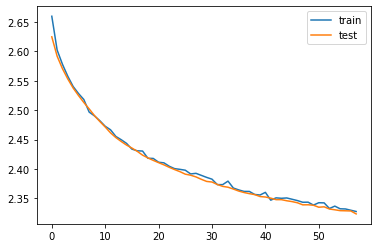

Training Loss at step 24010 : 2.566462755203247
Training Loss at step 24020 : 2.433549404144287
Training Loss at step 24030 : 2.223658800125122
Training Loss at step 24040 : 2.2024030685424805
Training Loss at step 24050 : 2.379925012588501
Training Loss at step 24060 : 2.2882580757141113
Training Loss at step 24070 : 2.3249151706695557
Training Loss at step 24080 : 2.3705053329467773
Training Loss at step 24090 : 2.3763420581817627
Training Loss at step 24100 : 2.2545928955078125
Training Loss at step 24110 : 2.2683746814727783
Training Loss at step 24120 : 2.244476318359375
Training Loss at step 24130 : 2.38391375541687
Training Loss at step 24140 : 2.324241876602173
Training Loss at step 24150 : 2.209763526916504
Training Loss at step 24160 : 2.597111225128174
Training Loss at step 24170 : 2.381978750228882
Training Loss at step 24180 : 2.173250436782837
Training Loss at step 24190 : 2.3323709964752197
Training Loss at step 24200 : 2.225999593734741
Training Loss at step 24210 : 2.1

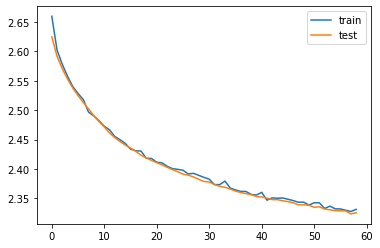

Training Loss at step 25010 : 2.2730519771575928
Training Loss at step 25020 : 2.3205463886260986
Training Loss at step 25030 : 2.2712812423706055
Training Loss at step 25040 : 2.476379632949829
Training Loss at step 25050 : 2.3898394107818604
Training Loss at step 25060 : 2.4906201362609863
Training Loss at step 25070 : 2.4053423404693604
Training Loss at step 25080 : 2.24635648727417
Training Loss at step 25090 : 2.3710439205169678
Training Loss at step 25100 : 2.352433443069458
Training Loss at step 25110 : 2.485159158706665
Training Loss at step 25120 : 2.3200643062591553
Training Loss at step 25130 : 2.3531458377838135
Training Loss at step 25140 : 2.549025058746338
Training Loss at step 25150 : 2.3785810470581055
Training Loss at step 25160 : 2.3249881267547607
Training Loss at step 25170 : 2.3517978191375732
Training Loss at step 25180 : 2.3000741004943848
Training Loss at step 25190 : 2.398505926132202
Training Loss at step 25200 : 2.426600217819214
Training Loss at step 25210 

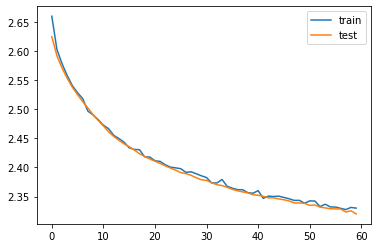

Training Loss at step 26010 : 2.2797842025756836
Training Loss at step 26020 : 2.3048572540283203
Training Loss at step 26030 : 2.233436346054077
Training Loss at step 26040 : 2.4393258094787598
Training Loss at step 26050 : 2.324248790740967
Training Loss at step 26060 : 2.2755680084228516
Training Loss at step 26070 : 2.3744959831237793
Training Loss at step 26080 : 2.410285234451294
Training Loss at step 26090 : 2.1860194206237793
Training Loss at step 26100 : 2.2602078914642334
Training Loss at step 26110 : 2.42598032951355
Training Loss at step 26120 : 2.3144724369049072
Training Loss at step 26130 : 2.4219348430633545
Training Loss at step 26140 : 2.3639423847198486
Training Loss at step 26150 : 2.3815879821777344
Training Loss at step 26160 : 2.3119075298309326
Training Loss at step 26170 : 2.385999917984009
Training Loss at step 26180 : 2.2819323539733887
Training Loss at step 26190 : 2.210422992706299
Training Loss at step 26200 : 2.4085981845855713
Training Loss at step 26210

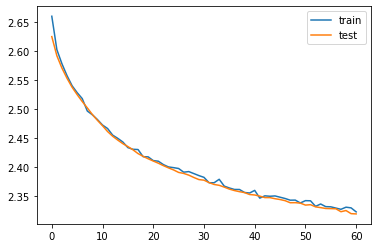

Training Loss at step 27010 : 2.2367138862609863
Training Loss at step 27020 : 2.5050673484802246
Training Loss at step 27030 : 2.294022798538208
Training Loss at step 27040 : 2.307008743286133
Training Loss at step 27050 : 2.2988457679748535
Training Loss at step 27060 : 2.1306121349334717
Training Loss at step 27070 : 2.414252281188965
Training Loss at step 27080 : 2.2180628776550293
Training Loss at step 27090 : 2.508855104446411
Training Loss at step 27100 : 2.247927188873291
Training Loss at step 27110 : 2.135559320449829
Training Loss at step 27120 : 2.1910855770111084
Training Loss at step 27130 : 2.3887648582458496
Training Loss at step 27140 : 2.174281120300293
Training Loss at step 27150 : 2.375049352645874
Training Loss at step 27160 : 2.4797799587249756
Training Loss at step 27170 : 2.2553088665008545
Training Loss at step 27180 : 2.3412528038024902
Training Loss at step 27190 : 2.3816709518432617
Training Loss at step 27200 : 2.418497323989868
Training Loss at step 27210 :

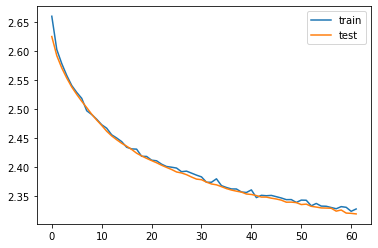

Training Loss at step 28010 : 2.252537965774536
Training Loss at step 28020 : 2.2875945568084717
Training Loss at step 28030 : 2.2067739963531494
Training Loss at step 28040 : 2.3503077030181885
Training Loss at step 28050 : 2.325972318649292
Training Loss at step 28060 : 2.357142686843872
Training Loss at step 28070 : 2.4168574810028076
Training Loss at step 28080 : 2.362149238586426
Training Loss at step 28090 : 2.4199583530426025
Training Loss at step 28100 : 2.359898567199707
Training Loss at step 28110 : 2.363487720489502
Training Loss at step 28120 : 2.303612232208252
Training Loss at step 28130 : 2.351144552230835
Training Loss at step 28140 : 2.462831497192383
Training Loss at step 28150 : 2.4033637046813965
Training Loss at step 28160 : 2.2367794513702393
Training Loss at step 28170 : 2.3742799758911133
Training Loss at step 28180 : 2.3097081184387207
Training Loss at step 28190 : 2.3882434368133545
Training Loss at step 28200 : 2.4048686027526855
Training Loss at step 28210 :

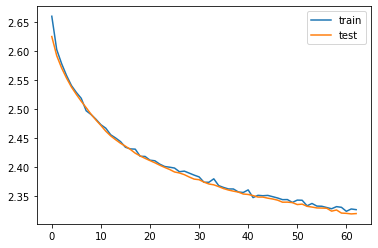

Training Loss at step 29010 : 2.425121545791626
Training Loss at step 29020 : 2.423703670501709
Training Loss at step 29030 : 2.4621741771698
Training Loss at step 29040 : 2.4056386947631836
Training Loss at step 29050 : 2.422966718673706
Training Loss at step 29060 : 2.3038806915283203
Training Loss at step 29070 : 2.4257986545562744
Training Loss at step 29080 : 2.2818825244903564
Training Loss at step 29090 : 2.4272587299346924
Training Loss at step 29100 : 2.2578322887420654
Training Loss at step 29110 : 2.24869966506958
Training Loss at step 29120 : 2.3093297481536865
Training Loss at step 29130 : 2.4548306465148926
Training Loss at step 29140 : 2.3833632469177246
Training Loss at step 29150 : 2.3351621627807617
Training Loss at step 29160 : 2.44476056098938
Training Loss at step 29170 : 2.216675281524658
Training Loss at step 29180 : 2.3523237705230713
Training Loss at step 29190 : 2.3693602085113525
Training Loss at step 29200 : 2.4083540439605713
Training Loss at step 29210 : 2

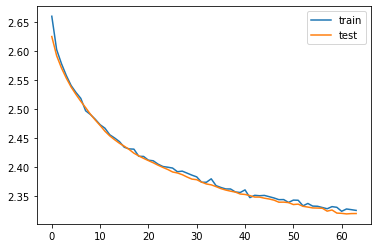

Training Loss at step 30010 : 2.270747661590576
Training Loss at step 30020 : 2.4345641136169434
Training Loss at step 30030 : 2.2568769454956055
Training Loss at step 30040 : 2.3759772777557373
Training Loss at step 30050 : 2.4239354133605957
Training Loss at step 30060 : 2.2722601890563965
Training Loss at step 30070 : 2.307197332382202
Training Loss at step 30080 : 2.3709776401519775
Training Loss at step 30090 : 2.2316768169403076
Training Loss at step 30100 : 2.3855783939361572
Training Loss at step 30110 : 2.5327281951904297
Training Loss at step 30120 : 2.3070266246795654
Training Loss at step 30130 : 2.2918334007263184
Training Loss at step 30140 : 2.2813680171966553
Training Loss at step 30150 : 2.353940963745117
Training Loss at step 30160 : 2.2015302181243896
Training Loss at step 30170 : 2.3088064193725586
Training Loss at step 30180 : 2.25429105758667
Training Loss at step 30190 : 2.412449836730957
Training Loss at step 30200 : 2.4067776203155518
Training Loss at step 3021

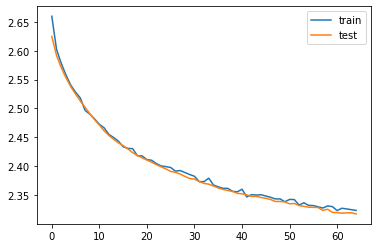

Training Loss at step 31010 : 2.2827367782592773
Training Loss at step 31020 : 2.3616514205932617
Training Loss at step 31030 : 2.2987561225891113
Training Loss at step 31040 : 2.3779075145721436
Training Loss at step 31050 : 2.2295145988464355
Training Loss at step 31060 : 2.1849417686462402
Training Loss at step 31070 : 2.295128345489502
Training Loss at step 31080 : 2.3359298706054688
Training Loss at step 31090 : 2.236429214477539
Training Loss at step 31100 : 2.349106550216675
Training Loss at step 31110 : 2.238135814666748
Training Loss at step 31120 : 2.4465229511260986
Training Loss at step 31130 : 2.230358600616455
Training Loss at step 31140 : 2.448406457901001
Training Loss at step 31150 : 2.286992311477661
Training Loss at step 31160 : 2.3424994945526123
Training Loss at step 31170 : 2.215223550796509
Training Loss at step 31180 : 2.261592149734497
Training Loss at step 31190 : 2.119497537612915
Training Loss at step 31200 : 2.317190647125244
Training Loss at step 31210 : 2

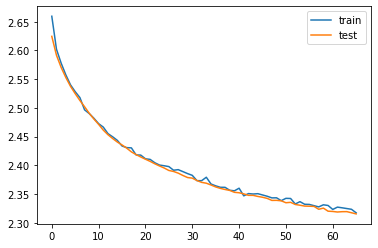

Training Loss at step 32010 : 2.336021661758423
Training Loss at step 32020 : 2.315727949142456
Training Loss at step 32030 : 2.23364520072937
Training Loss at step 32040 : 2.3873279094696045
Training Loss at step 32050 : 2.194918155670166
Training Loss at step 32060 : 2.3648383617401123
Training Loss at step 32070 : 2.362696886062622
Training Loss at step 32080 : 2.312702178955078
Training Loss at step 32090 : 2.303750514984131
Training Loss at step 32100 : 2.489194869995117
Training Loss at step 32110 : 2.283149242401123
Training Loss at step 32120 : 2.335489511489868
Training Loss at step 32130 : 2.425478935241699
Training Loss at step 32140 : 2.452707052230835
Training Loss at step 32150 : 2.429964303970337
Training Loss at step 32160 : 2.2755019664764404
Training Loss at step 32170 : 2.322331428527832
Training Loss at step 32180 : 2.286738634109497
Training Loss at step 32190 : 2.3802943229675293
Training Loss at step 32200 : 2.384369134902954
Training Loss at step 32210 : 2.19839

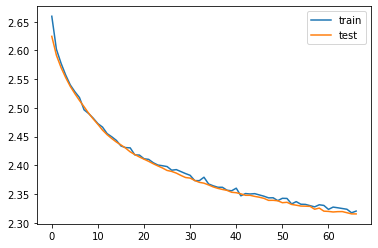

Training Loss at step 33010 : 2.3142948150634766
Training Loss at step 33020 : 2.291597366333008
Training Loss at step 33030 : 2.3045120239257812
Training Loss at step 33040 : 2.498453378677368
Training Loss at step 33050 : 2.2894673347473145
Training Loss at step 33060 : 2.3982510566711426
Training Loss at step 33070 : 2.341876268386841
Training Loss at step 33080 : 2.479583501815796
Training Loss at step 33090 : 2.1756222248077393
Training Loss at step 33100 : 2.4009945392608643
Training Loss at step 33110 : 2.486668109893799
Training Loss at step 33120 : 2.2076072692871094
Training Loss at step 33130 : 2.133183240890503
Training Loss at step 33140 : 2.261887311935425
Training Loss at step 33150 : 2.338064670562744
Training Loss at step 33160 : 2.2870213985443115
Training Loss at step 33170 : 2.4217641353607178
Training Loss at step 33180 : 2.398231267929077
Training Loss at step 33190 : 2.0113956928253174
Training Loss at step 33200 : 2.411505699157715
Training Loss at step 33210 : 

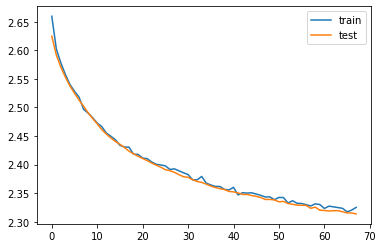

Training Loss at step 34010 : 2.3776535987854004
Training Loss at step 34020 : 2.3476767539978027
Training Loss at step 34030 : 2.379648208618164
Training Loss at step 34040 : 2.283828020095825
Training Loss at step 34050 : 2.2914206981658936
Training Loss at step 34060 : 2.32416033744812
Training Loss at step 34070 : 2.423318862915039
Training Loss at step 34080 : 2.3675053119659424
Training Loss at step 34090 : 2.385119676589966
Training Loss at step 34100 : 2.3465874195098877
Training Loss at step 34110 : 2.211543560028076
Training Loss at step 34120 : 2.2699763774871826
Training Loss at step 34130 : 2.237590789794922
Training Loss at step 34140 : 2.1739304065704346
Training Loss at step 34150 : 2.30873703956604
Training Loss at step 34160 : 2.2329020500183105
Training Loss at step 34170 : 2.146592617034912
Training Loss at step 34180 : 2.192025661468506
Training Loss at step 34190 : 2.2702410221099854
Training Loss at step 34200 : 2.3515913486480713
Training Loss at step 34210 : 2.

In [25]:
only_spans = False

model = FullContextSpanClassifier(labels).to(device)
model.train()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

t1 = time.time()

train_losses_per_test = []
test_losses = []

for epoch in range(n_epochs):
    batch_losses = []
    for step in range(len(train_x_batches)):
        
        batch_losses.append(train_model_on_batch(model, train_x_batches[step], train_y_batches[step], optimizer, articles, only_spans, tokenizer, device, report_loss=step%10==0))
        
        if step % batches_before_test == 0 and step > 0:
            train_losses_per_test.append(sum(batch_losses)/len(batch_losses))
            batch_losses = []
            test_loss,preds = test_model(model, tokenizer, test_x_batches, test_y_batches, articles, only_spans, device, loss_fn)
            test_losses.append(test_loss)
            plot_losses(train_losses_per_test, test_losses)   
            
    #after each epoch, save model checkpoint...
    torch.save(model.state_dict(), "./roberta-mfc-with-context-ce-loss-epoch-{}.pt".format(epoch))
    print("Saved checkpoing model for epoch", epoch)

In [27]:
only_spans=False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FullContextSpanClassifier(labels).to(device)
model.load_state_dict(torch.load("./roberta-mfc-with-context-ce-loss-epoch-1.pt"))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Model Accuracy: 0.5715725806451613


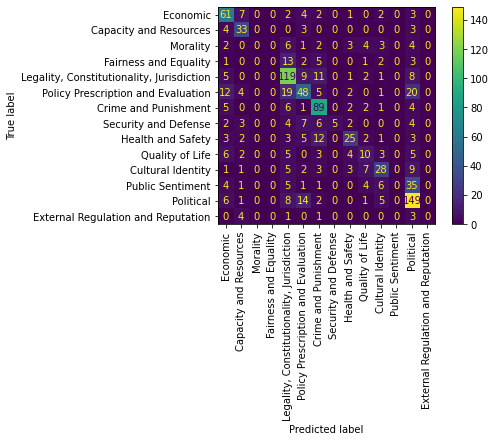

In [31]:
_,test_results = test_model(model, tokenizer, test_x_batches, test_y_batches, articles, only_spans, device)
preds = [t[0] for t in test_results]
reals = [t[1] for t in test_results]


codes = [codebook[str(label)] for label in labels if labels.index(label) <= max(max(reals),max(preds))]

disp = ConfusionMatrixDisplay(
        confusion_matrix(reals, preds),
        display_labels=codes
    )
disp.plot()
plt.xticks(rotation=90)
plt.show()


In [29]:
from sklearn.metrics import f1_score as f1

test_results = test_model(model, tokenizer, test_x_batches, test_y_batches, articles, only_spans, device)
preds = [t[0] for t in test_results]
reals = [t[1] for t in test_results]

label_set = set(reals+preds)

codes = labels
with open("../../mfc_v4.0/codes.json", "r") as f:
    codebook = json.load(f)
    codes = [codebook[str(label)] for label in labels if labels.index(label) <= max(max(reals),max(preds))]
    
print("Micro F1 Score:", f1(reals, preds, average='micro'))
print("Macro F1 Score:", f1(reals, preds, average='macro'))
print("Weighted F1 Score:", f1(reals, preds, average='weighted'))
f1_dict = dict([(codes[label], f1([int(e==label) for e in reals],[int(e==label) for e in preds])) for label in label_set])
print("All F1 Scores:")
for key in f1_dict:
    print(key, f1_dict[key])

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Model Accuracy: 0.5715725806451613
Micro F1 Score: 0.5715725806451613
Macro F1 Score: 0.38250495627299835
Weighted F1 Score: 0.5216768347997722
All F1 Scores:
Economic 0.6288659793814433
Capacity and Resources 0.6534653465346535
Morality 0.0
Fairness and Equality 0.0
Legality, Constitutionality, Jurisdiction 0.6761363636363635
Policy Prescription and Evaluation 0.46153846153846156
Crime and Punishment 0.7063492063492064
Security and Defense 0.2631578947368421
Health and Safety 0.5050505050505051
Quality of Life 0.28169014084507044
Cultural Identity 0.5
Public Sentiment 0.0
Political 0.6788154897494306
External Regulation and Reputation 0.0
